In [ ]:
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

In [16]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Identifying Credit Card Default with Machine Learning

All the recipes use `scikit-learn` version `0.21` (unless specified otherwise). From `0.22`, the default settings of selected estimators are changed. For example, in the case of the `RandomForestClassifier`, the default setting of `n_estimators` was changed from 10 to 100. This will cause discrepancies with the results presented in the book.

## BONUS: Getting the data and preparing for book

This is a part not covered in the book. We download the considered dataset from the website of the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). The dataset originally does not contain missing values and the categorical variables are already encoded as numbers. To show the entire pipeline of working and preparing potentially messy data, we apply some transformations:

* we encoded the gender, education and marital status related variables to strings
* we introduced missing values to some observations (0.5% of the entire sample, selected randomly per column - the total percentage of rows with at least one missing value will be higher)
* some observed values for features such as level of education, payment status, etc. are outside of the range of possible categories defined by the authors. As this problem affects many observations, we encode new, undescribed categories as either 'Others' (when there was already such a category) or 'Unknown' (in the case of payment status).

The reason for selecting only a small fraction of values to be missing is that we do not want to significantly change the underlying structure/patterns in the data.

In [1]:
import pandas as pd
import numpy as np
import random

In [ ]:
# downloading the data 
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

In [ ]:
# loading the data from Excel
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls', skiprows=1, index_col=0)
df


LIMIT_BAL  SEX  ...  PAY_AMT6  default payment next month
ID                     ...                                      
1          20000    2  ...         0                           1
2         120000    2  ...      2000                           1
3          90000    2  ...      5000                           0
4          50000    2  ...      1000                           0
5          50000    1  ...       679                           0
...          ...  ...  ...       ...                         ...
29996     220000    1  ...      1000                           0
29997     150000    1  ...         0                           0
29998      30000    1  ...      3100                           1
29999      80000    1  ...      1804                           1
30000      50000    1  ...      1000                           1

[30000 rows x 24 columns]

In [ ]:
# rename columns
df.columns = df.columns.str.lower().str.replace(" ", "_")
df

limit_bal  sex  ...  pay_amt6  default_payment_next_month
ID                     ...                                      
1          20000    2  ...         0                           1
2         120000    2  ...      2000                           1
3          90000    2  ...      5000                           0
4          50000    2  ...      1000                           0
5          50000    1  ...       679                           0
...          ...  ...  ...       ...                         ...
29996     220000    1  ...      1000                           0
29997     150000    1  ...         0                           0
29998      30000    1  ...      3100                           1
29999      80000    1  ...      1804                           1
30000      50000    1  ...      1000                           1

[30000 rows x 24 columns]

In [ ]:
months = ['sep', 'aug', 'jul', 'jun', 'may', 'apr']
variables = ['payment_status', 'bill_statement', 'previous_payment']
new_column_names = [x + '_' + y for x in variables for y in months]
rename_dict = {x: y for x, y in zip(df.loc[:, 'pay_0':'pay_amt6'].columns, new_column_names)}
df.rename(columns=rename_dict, inplace=True)
df

limit_bal  sex  ...  previous_payment_apr  default_payment_next_month
ID                     ...                                                  
1          20000    2  ...                     0                           1
2         120000    2  ...                  2000                           1
3          90000    2  ...                  5000                           0
4          50000    2  ...                  1000                           0
5          50000    1  ...                   679                           0
...          ...  ...  ...                   ...                         ...
29996     220000    1  ...                  1000                           0
29997     150000    1  ...                     0                           0
29998      30000    1  ...                  3100                           1
29999      80000    1  ...                  1804                           1
30000      50000    1  ...                  1000                           1

[30000 rows x 24 columns]

In [ ]:
# creating dicts to map number to strings
gender_dict = {1: 'Male', 
               2: 'Female'}
education_dict = {0: 'Others',
                  1: 'Graduate school', 
                  2: 'University', 
                  3: 'High school', 
                  4: 'Others',
                  5: 'Others',
                  6: 'Others'}
marital_status_dict = {0: 'Others', 
                       1: 'Married', 
                       2: 'Single', 
                       3: 'Others'}
payment_status = {-2: 'Unknown',
                  -1: 'Payed duly',
                  0: 'Unknown',
                  1: 'Payment delayed 1 month',
                  2: 'Payment delayed 2 months',
                  3: 'Payment delayed 3 months',
                  4: 'Payment delayed 4 months',
                  5: 'Payment delayed 5 months',
                  6: 'Payment delayed 6 months',
                  7: 'Payment delayed 7 months',
                  8: 'Payment delayed 8 months',
                  9: 'Payment delayed >= 9 months'}

# # map numbers to strings
df.sex = df.sex.map(gender_dict)
df.education = df.education.map(education_dict)
df.marriage = df.marriage.map(marital_status_dict)

for column in [x for x in df.columns if ('status' in x)]:
    df[column] = df[column].map(payment_status)

# define the ratio of missing values to introduce
RATIO_MISSING = 0.005

# input missing values to selected columns
random_state = np.random.RandomState(42)
for column in ['sex', 'education', 'marriage', 'age']:
    df.loc[df.sample(frac=RATIO_MISSING, random_state=random_state).index, column] = ''

# reset index
df.reset_index(drop=True, inplace=True)
df
# save to csv
#df.to_csv('../Datasets/credit_card_default.csv')

limit_bal     sex  ... previous_payment_apr default_payment_next_month
0          20000  Female  ...                    0                          1
1         120000  Female  ...                 2000                          1
2          90000  Female  ...                 5000                          0
3          50000  Female  ...                 1000                          0
4          50000    Male  ...                  679                          0
...          ...     ...  ...                  ...                        ...
29995     220000          ...                 1000                          0
29996     150000    Male  ...                    0                          0
29997      30000    Male  ...                 3100                          1
29998      80000    Male  ...                 1804                          1
29999      50000    Male  ...                 1000                          1

[30000 rows x 24 columns]

## Loading the data and managing data types

### How to do it...

1. Import the libraries:

In [ ]:
import pandas as pd

2. Preview the CSV file:

In [ ]:
!head -n 5 credit_card_default.csv

head: credit_card_default.csv: No such file or directory


3. Load the data from the CSV file:

In [2]:
df = pd.read_csv('https://github.com/PacktPublishing/Python-for-Finance-Cookbook/blob/master/Datasets/credit_card_default.csv?raw=true', index_col=0, na_values='')
print(f'The DataFrame has {len(df)} rows and {df.shape[1]} columns.')
df.head()

The DataFrame has 30000 rows and 24 columns.


limit_bal     sex  ... previous_payment_apr default_payment_next_month
0      20000  Female  ...                    0                          1
1     120000  Female  ...                 2000                          1
2      90000  Female  ...                 5000                          0
3      50000  Female  ...                 1000                          0
4      50000    Male  ...                  679                          0

[5 rows x 24 columns]

4. Separate the features from the target:

In [3]:
X = df.copy()
y = X.pop('default_payment_next_month')

In [4]:
y

0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default_payment_next_month, Length: 30000, dtype: int64

### There's more

In [10]:
df

limit_bal     sex  ... previous_payment_apr default_payment_next_month
0          20000  Female  ...                    0                          1
1         120000  Female  ...                 2000                          1
2          90000  Female  ...                 5000                          0
3          50000  Female  ...                 1000                          0
4          50000    Male  ...                  679                          0
...          ...     ...  ...                  ...                        ...
29995     220000     NaN  ...                 1000                          0
29996     150000    Male  ...                    0                          0
29997      30000    Male  ...                 3100                          1
29998      80000    Male  ...                 1804                          1
29999      50000    Male  ...                 1000                          1

[30000 rows x 24 columns]

In [5]:
df.dtypes

limit_bal                       int64
sex                            object
education                      object
marriage                       object
age                           float64
payment_status_sep             object
payment_status_aug             object
payment_status_jul             object
payment_status_jun             object
payment_status_may             object
payment_status_apr             object
bill_statement_sep              int64
bill_statement_aug              int64
bill_statement_jul              int64
bill_statement_jun              int64
bill_statement_may              int64
bill_statement_apr              int64
previous_payment_sep            int64
previous_payment_aug            int64
previous_payment_jul            int64
previous_payment_jun            int64
previous_payment_may            int64
previous_payment_apr            int64
default_payment_next_month      int64
dtype: object

In [6]:
def get_df_memory_usage(df, top_columns=5):
    '''
    Function for quick analysis of a pandas DataFrame's memory usage.
    It prints the top `top_columns` columns in terms of memory usage 
    and the total usage of the DataFrame.
    
    Parameters
    ------------
    df : pd.DataFrame
        DataFrame to be inspected
    top_columns : int
        Number of top columns (in terms of memory used) to display
    '''
    print('Memory usage ----')
    memory_per_column = df.memory_usage(deep=True) / 1024 ** 2
    print(f'Top {top_columns} columns by memory (MB):')
    print(memory_per_column.sort_values(ascending=False) \
                           .head(top_columns))
    print(f'Total size: {memory_per_column.sum():.4f} MB')

In [7]:
get_df_memory_usage(df, 5)

Memory usage ----
Top 5 columns by memory (MB):
education             1.965001
payment_status_sep    1.954342
payment_status_aug    1.920288
payment_status_jul    1.916343
payment_status_jun    1.904229
dtype: float64
Total size: 20.7012 MB


In [8]:
df_cat = df.copy()
object_columns = df_cat.select_dtypes(include='object').columns
df_cat[object_columns] = df_cat[object_columns].astype('category')

In [9]:
get_df_memory_usage(df_cat)

Memory usage ----
Top 5 columns by memory (MB):
default_payment_next_month    0.228882
bill_statement_may            0.228882
limit_bal                     0.228882
age                           0.228882
previous_payment_apr          0.228882
dtype: float64
Total size: 3.9266 MB


With this simple transformation, we managed to reduce the size (memory-wise)
of the DataFrame by ~80%. We could also downcast the integer columns
(currently using the int64 type) to something much smaller memory-wise, but
for that, we would need to inspect the min and max values for each column and
determine which type would be the best fit. We do not do this here; however, the
process of using astype is the same.

In [ ]:
column_dtypes = {'education': 'category', 
                 'marriage': 'category', 
                 'sex': 'category',
                 'payment_status_sep': 'category', 
                 'payment_status_aug': 'category', 
                 'payment_status_jul': 'category',       
                 'payment_status_jun': 'category', 
                 'payment_status_may': 'category', 
                 'payment_status_apr': 'category'}
df_cat2 = pd.read_csv('../Datasets/credit_card_default.csv', 
                      index_col=0, na_values='', 
                      dtype=column_dtypes)

In [ ]:
get_df_memory_usage(df_cat2)

Memory usage ----
Top 5 columns by memory (MB):
default_payment_next_month    0.228882
bill_statement_may            0.228882
limit_bal                     0.228882
age                           0.228882
previous_payment_apr          0.228882
dtype: float64
Total size: 3.9265 MB


In [ ]:
df_cat.equals(df_cat2)

True

## Exploratory Data Analysis

### How to do it...

1. Import the libraries:

In [12]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.io as pio

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2. Get summary statistics for numeric variables:

In [13]:
df.describe().transpose().round(2)

count       mean  ...        75%        max
limit_bal                   30000.0  167484.32  ...  240000.00  1000000.0
age                         29850.0      35.49  ...      41.00       79.0
bill_statement_sep          30000.0   51223.33  ...   67091.00   964511.0
bill_statement_aug          30000.0   49179.08  ...   64006.25   983931.0
bill_statement_jul          30000.0   47013.15  ...   60164.75  1664089.0
bill_statement_jun          30000.0   43262.95  ...   54506.00   891586.0
bill_statement_may          30000.0   40311.40  ...   50190.50   927171.0
bill_statement_apr          30000.0   38871.76  ...   49198.25   961664.0
previous_payment_sep        30000.0    5663.58  ...    5006.00   873552.0
previous_payment_aug        30000.0    5921.16  ...    5000.00  1684259.0
previous_payment_jul        30000.0    5225.68  ...    4505.00   896040.0
previous_payment_jun        30000.0    4826.08  ...    4013.25   621000.0
previous_payment_may        30000.0    4799.39  ...    4031.50   426529.0
previous_payment_apr        30000.0    5215.50  ...    4000.00   528666.0
default_payment_next_month  30000.0       0.22  ...       0.00        1.0

[15 rows x 8 columns]

3. Get summary statistics for categorical variables:

In [14]:
df.describe(include='object').transpose()

count unique         top   freq
sex                 29850      2      Female  18027
education           29850      4  University  13960
marriage            29850      3      Single  15891
payment_status_sep  30000     10     Unknown  17496
payment_status_aug  30000     10     Unknown  19512
payment_status_jul  30000     10     Unknown  19849
payment_status_jun  30000     10     Unknown  20803
payment_status_may  30000      9     Unknown  21493
payment_status_apr  30000      9     Unknown  21181

4. Plot the distribution of age and split it by gender:

In [18]:
df.loc[df.sex=='Male', 'age'].dropna()

4        57.0
5        37.0
6        29.0
9        35.0
13       30.0
         ... 
29994    34.0
29996    43.0
29997    37.0
29998    41.0
29999    46.0
Name: age, Length: 11767, dtype: float64

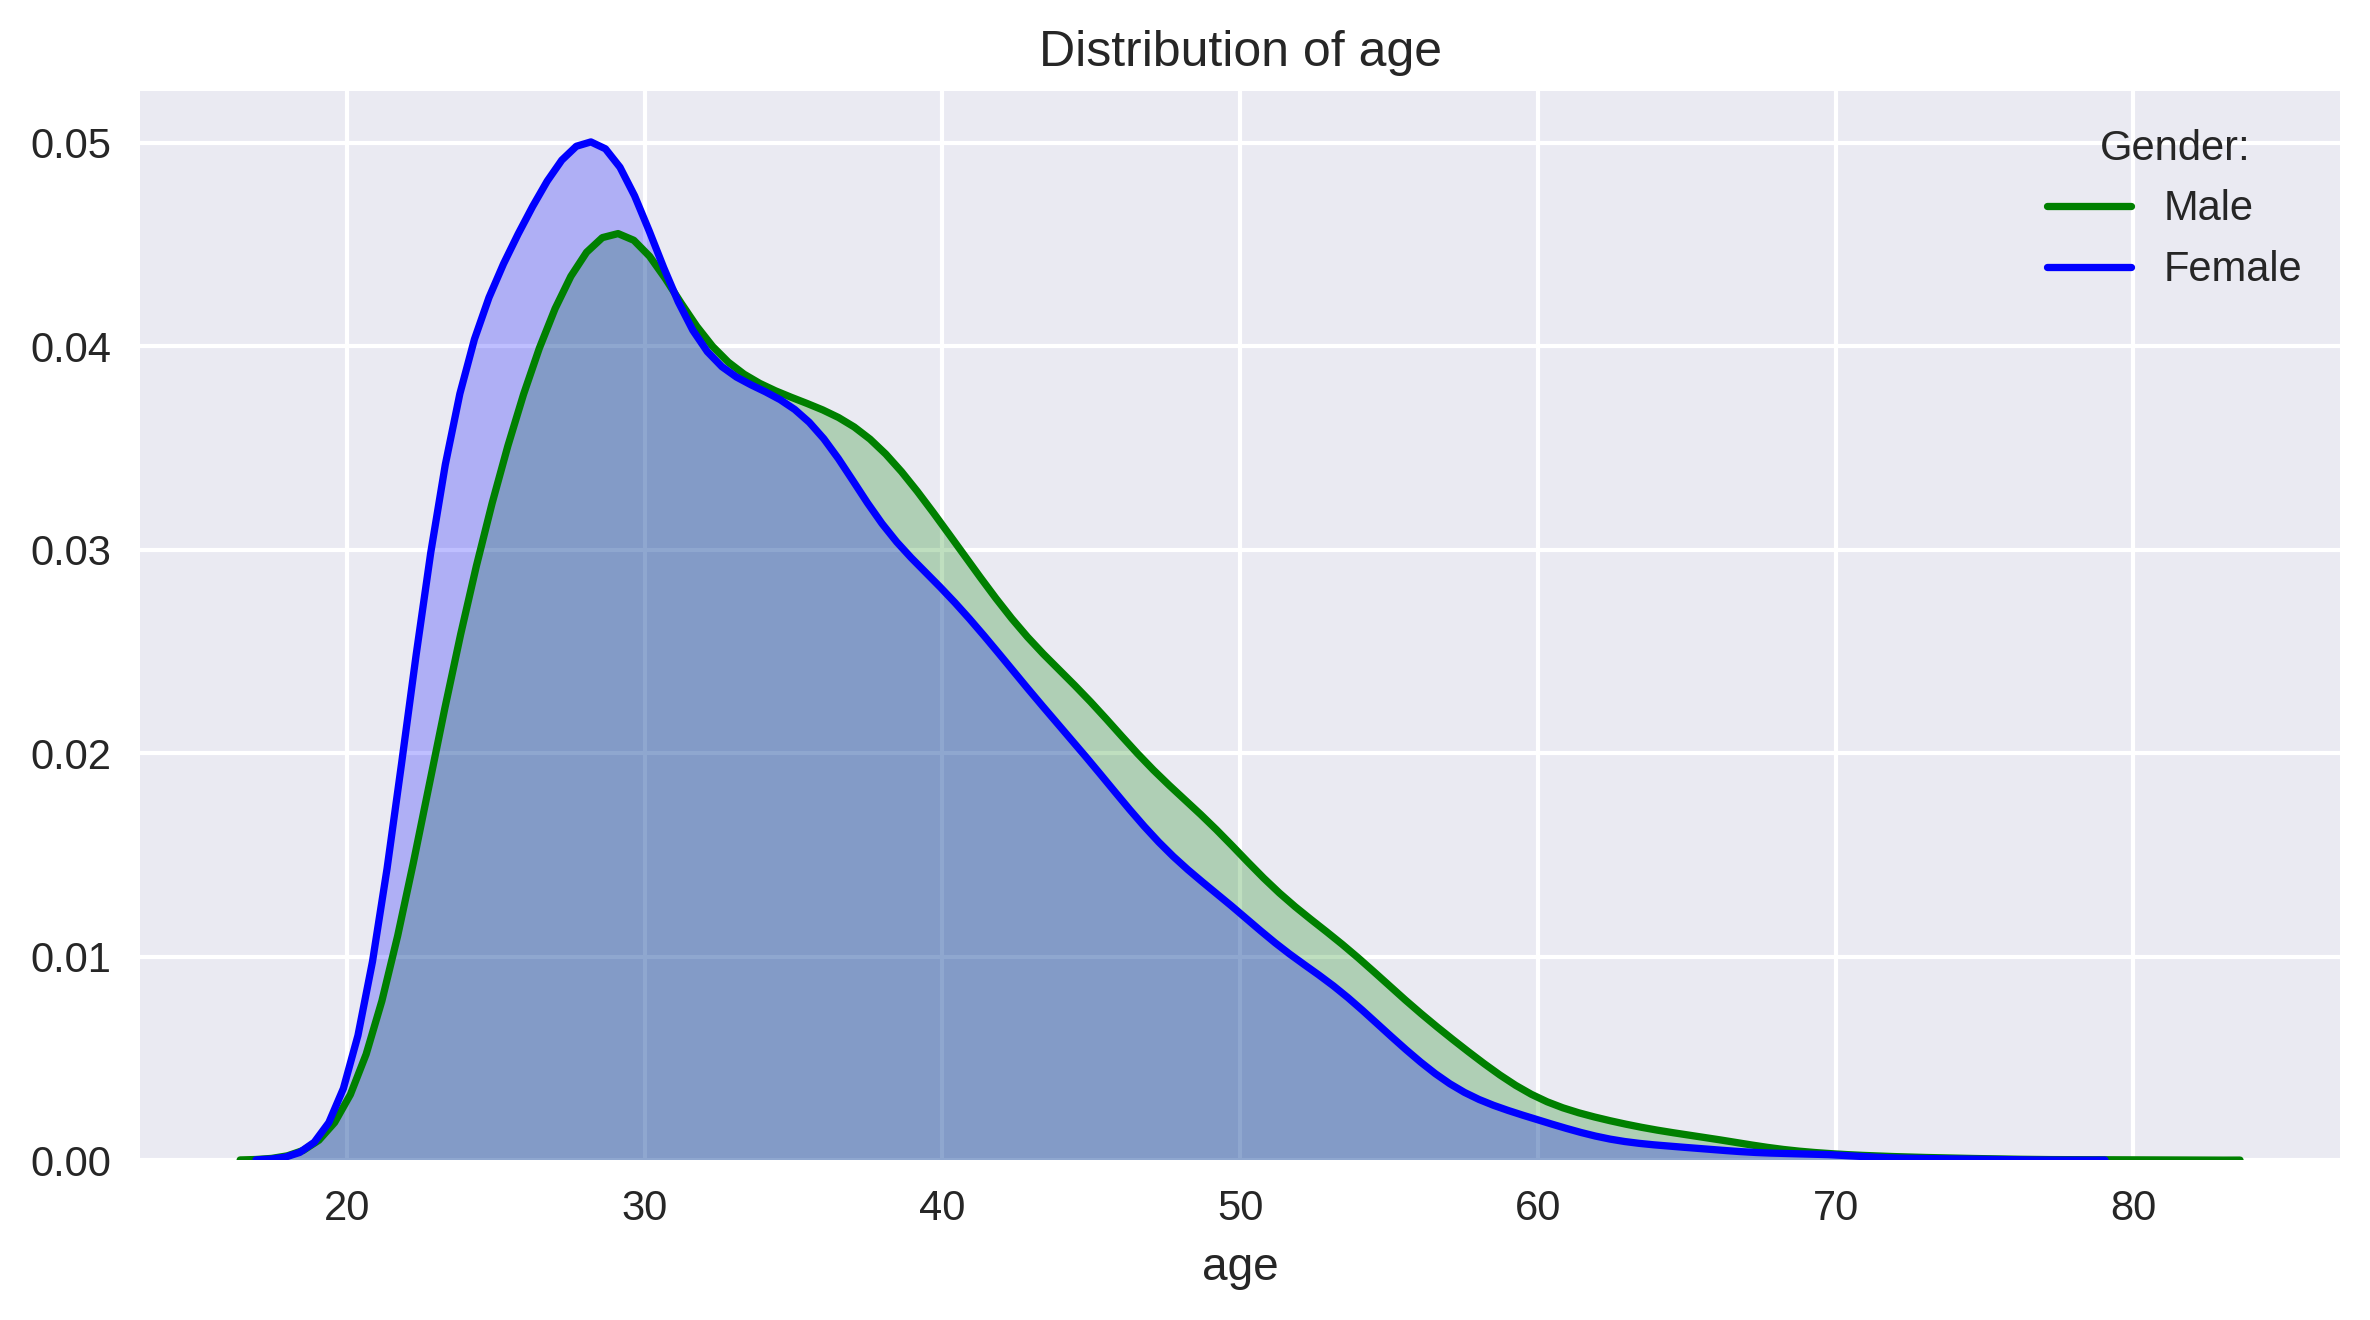

In [17]:
fig, ax = plt.subplots()
sns.distplot(df.loc[df.sex=='Male', 'age'].dropna(), 
             hist=False, color='green', 
             kde_kws={'shade': True},
             ax=ax, label='Male')
sns.distplot(df.loc[df.sex=='Female', 'age'].dropna(), 
             hist=False, color='blue', 
             kde_kws={'shade': True},
             ax=ax, label='Female')
ax.set_title('Distribution of age')
ax.legend(title='Gender:')

plt.tight_layout()
# plt.savefig('images/ch8_im5.png')
plt.show()

By analyzing the plot, we can say there is not much difference in the shape of the
distribution per gender. The female sample is slightly younger, on average.

As mentioned in the text, we can create a histogram (together with the KDE), by calling:

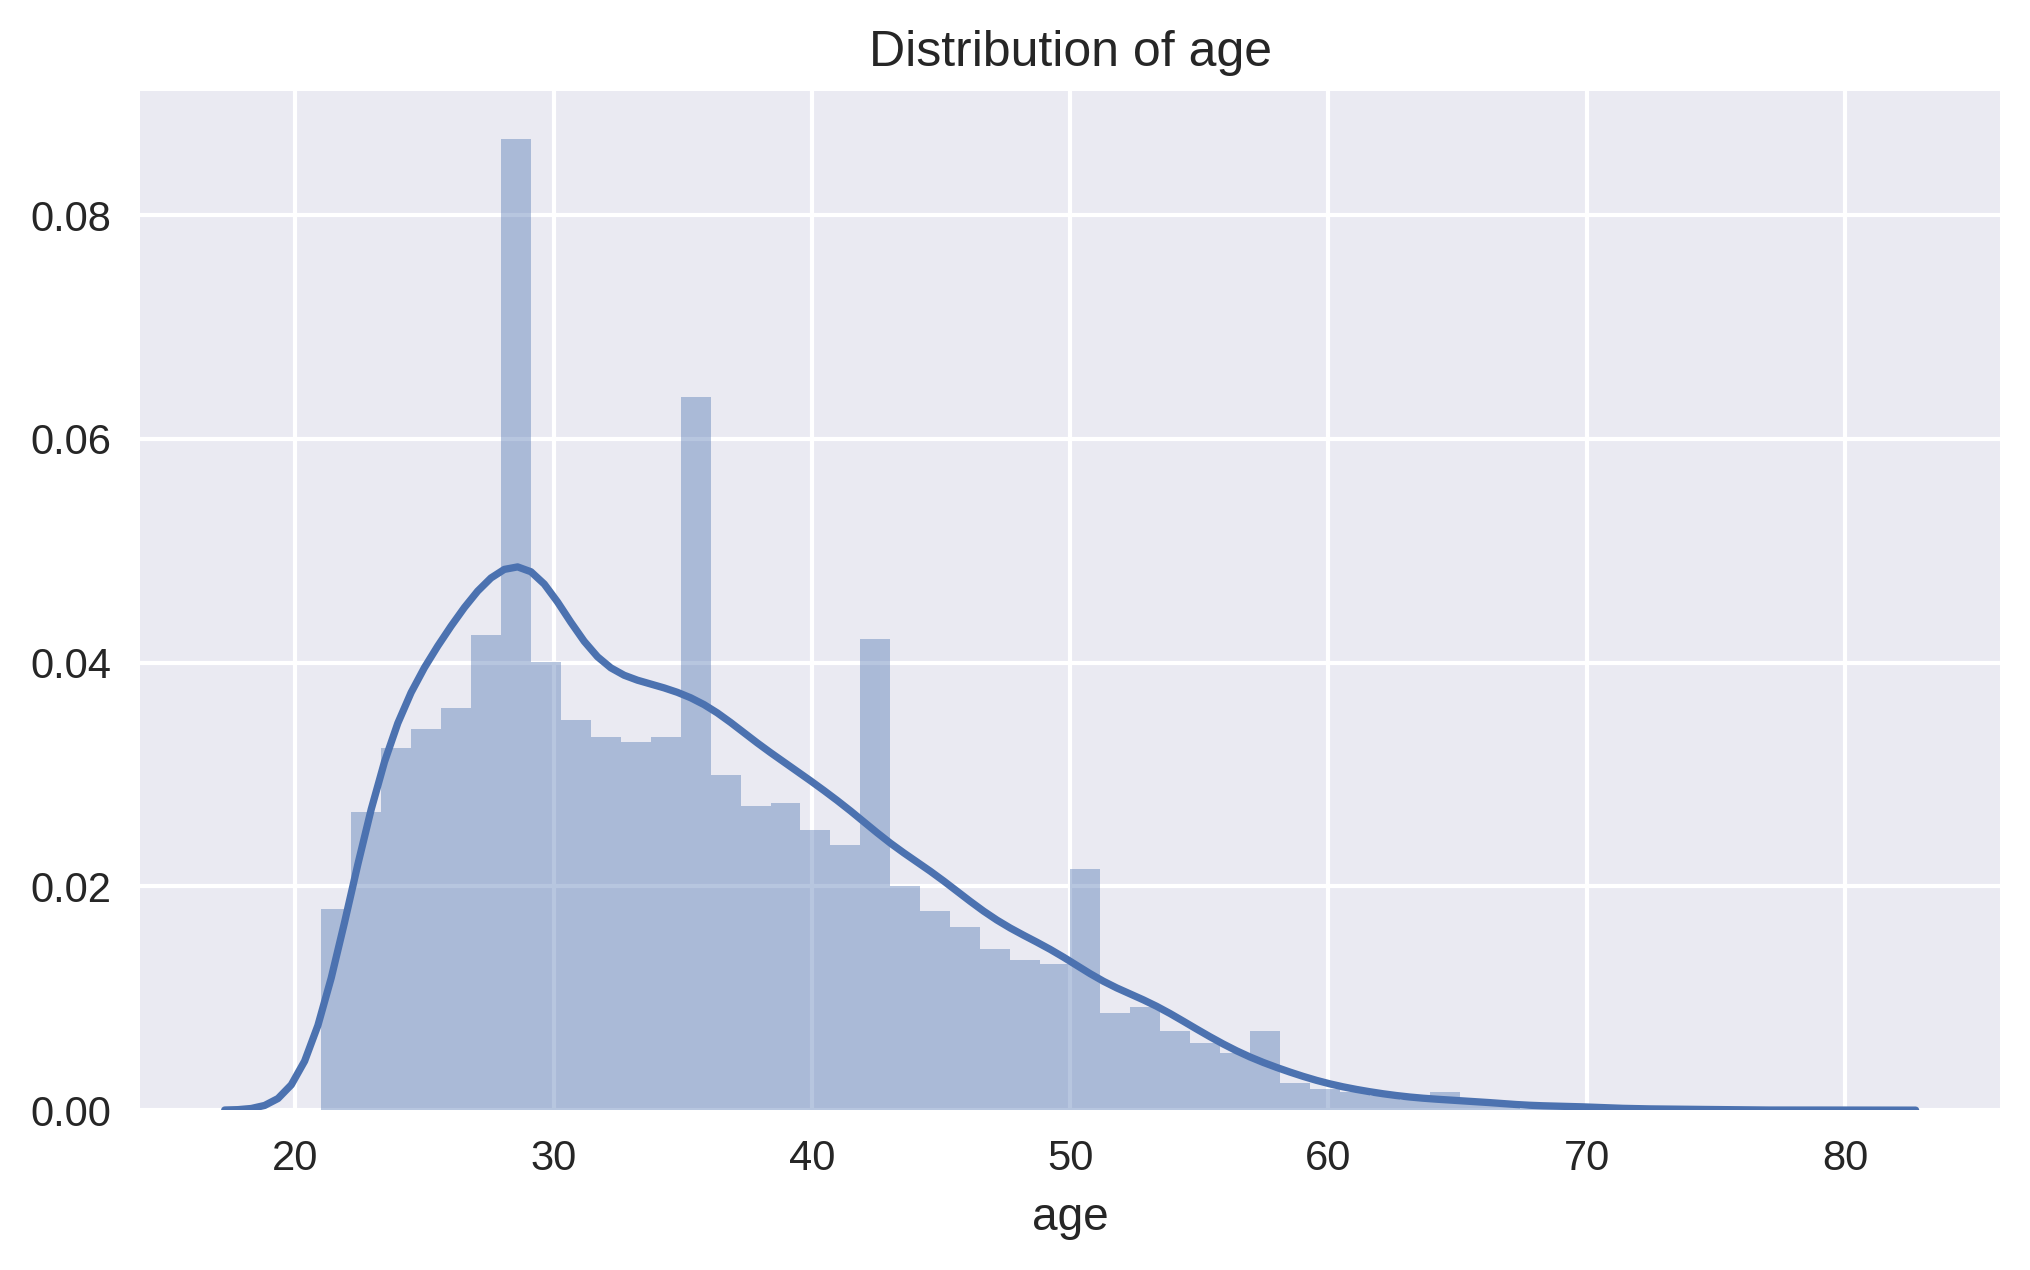

In [19]:
ax = sns.distplot(df.age.dropna(), )
ax.set_title('Distribution of age');

We noticed some spikes appearing every ~10 years and the reason for this is the binning. Below, we created the same histogram using `sns.countplot` and `plotly_express`. By doing so, each value of age has a separate bin and we can inspect the plot in detail. There are no such spikes in the following plots:

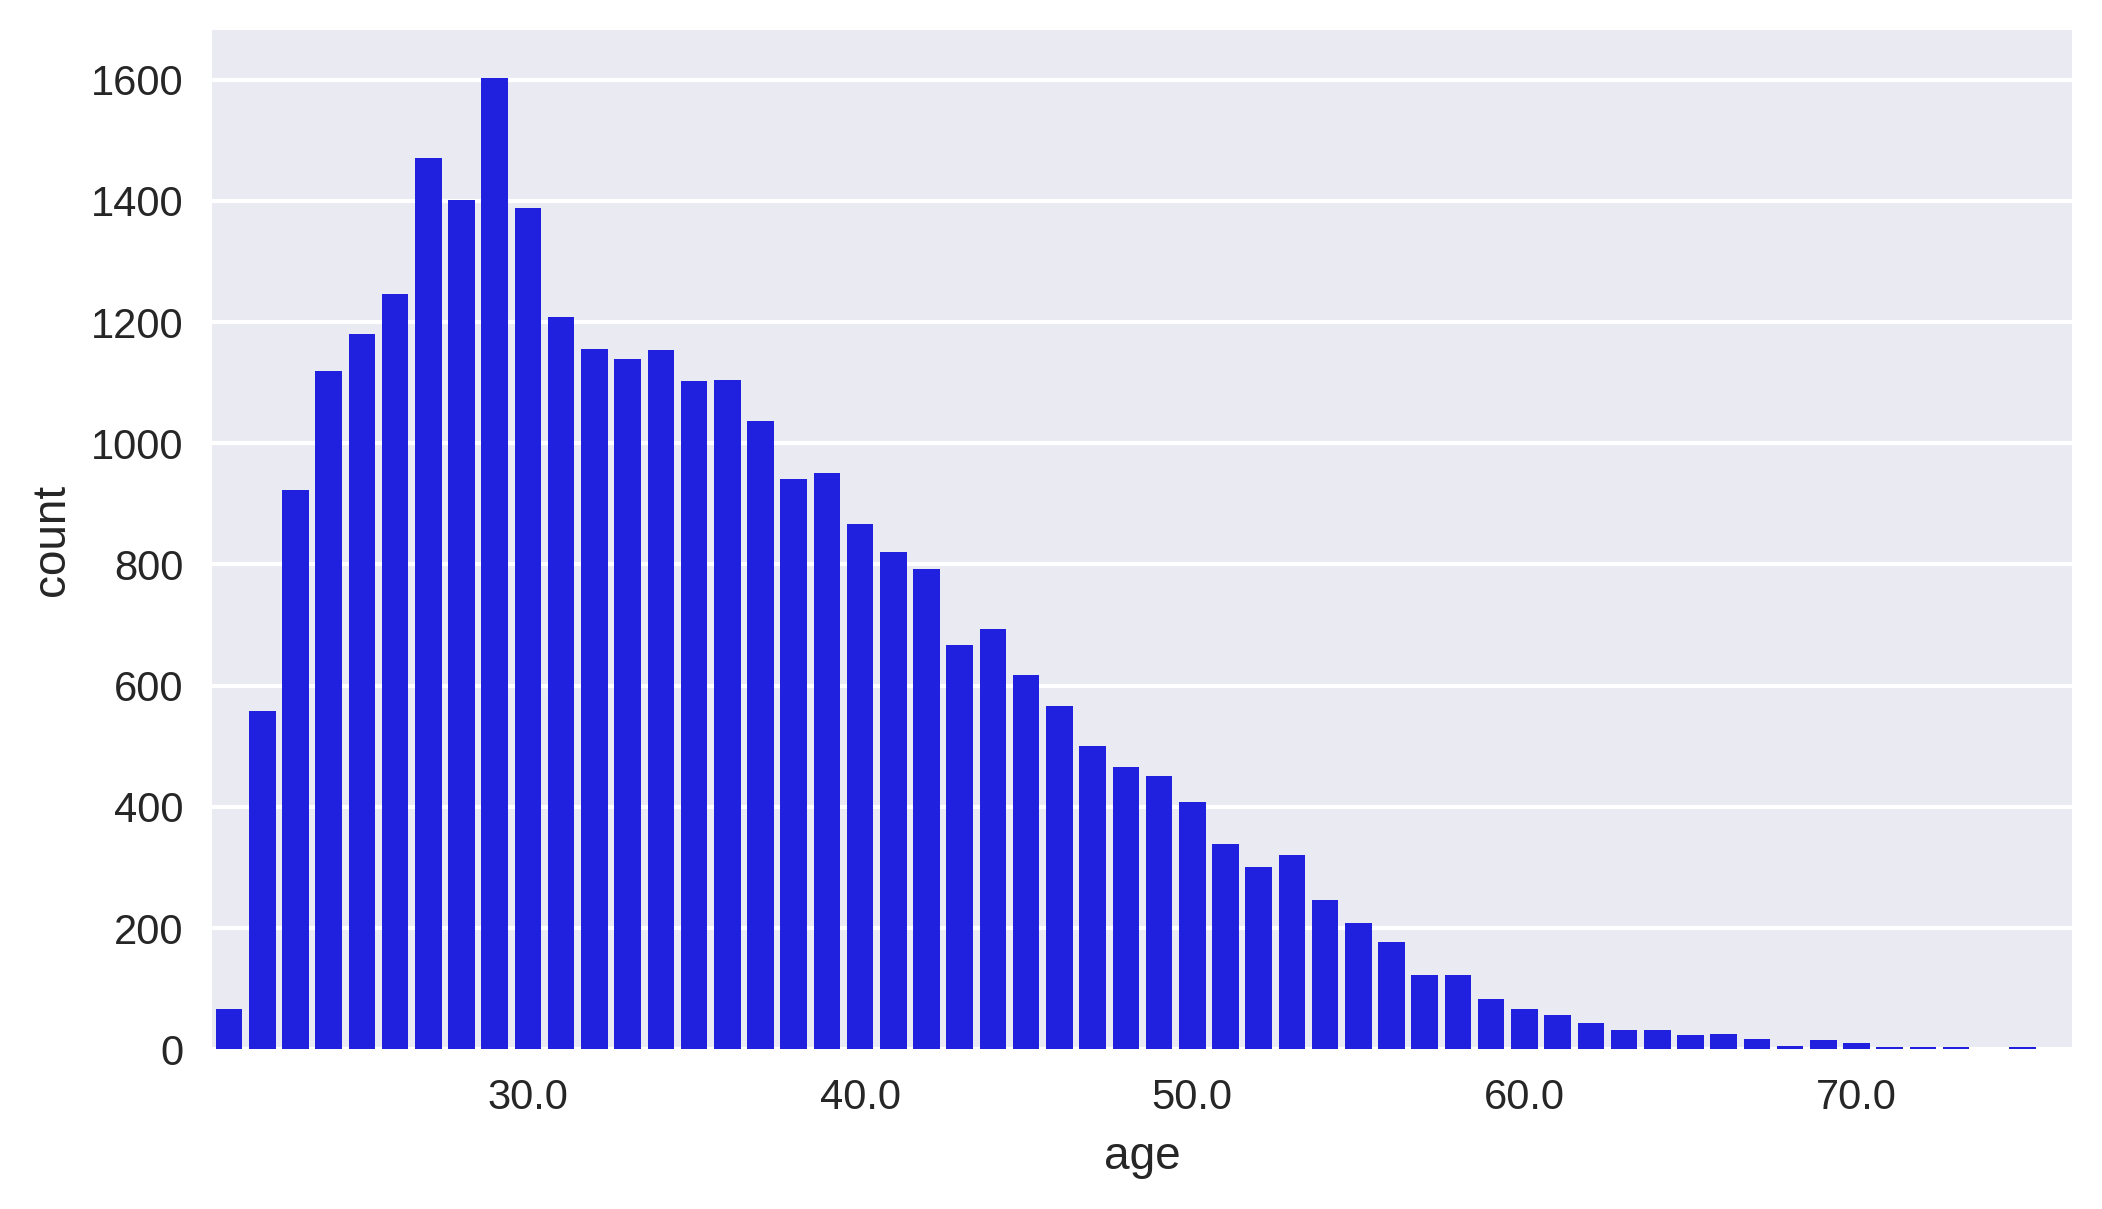

In [20]:
plot_ = sns.countplot(x=df.age.dropna(), color='blue')

for ind, label in enumerate(plot_.get_xticklabels()):
    if int(float(label.get_text())) % 10 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

In [21]:
px.histogram(df, x='age', title = 'Distribution of age')

5. Plot a `pairplot` of selected variables:

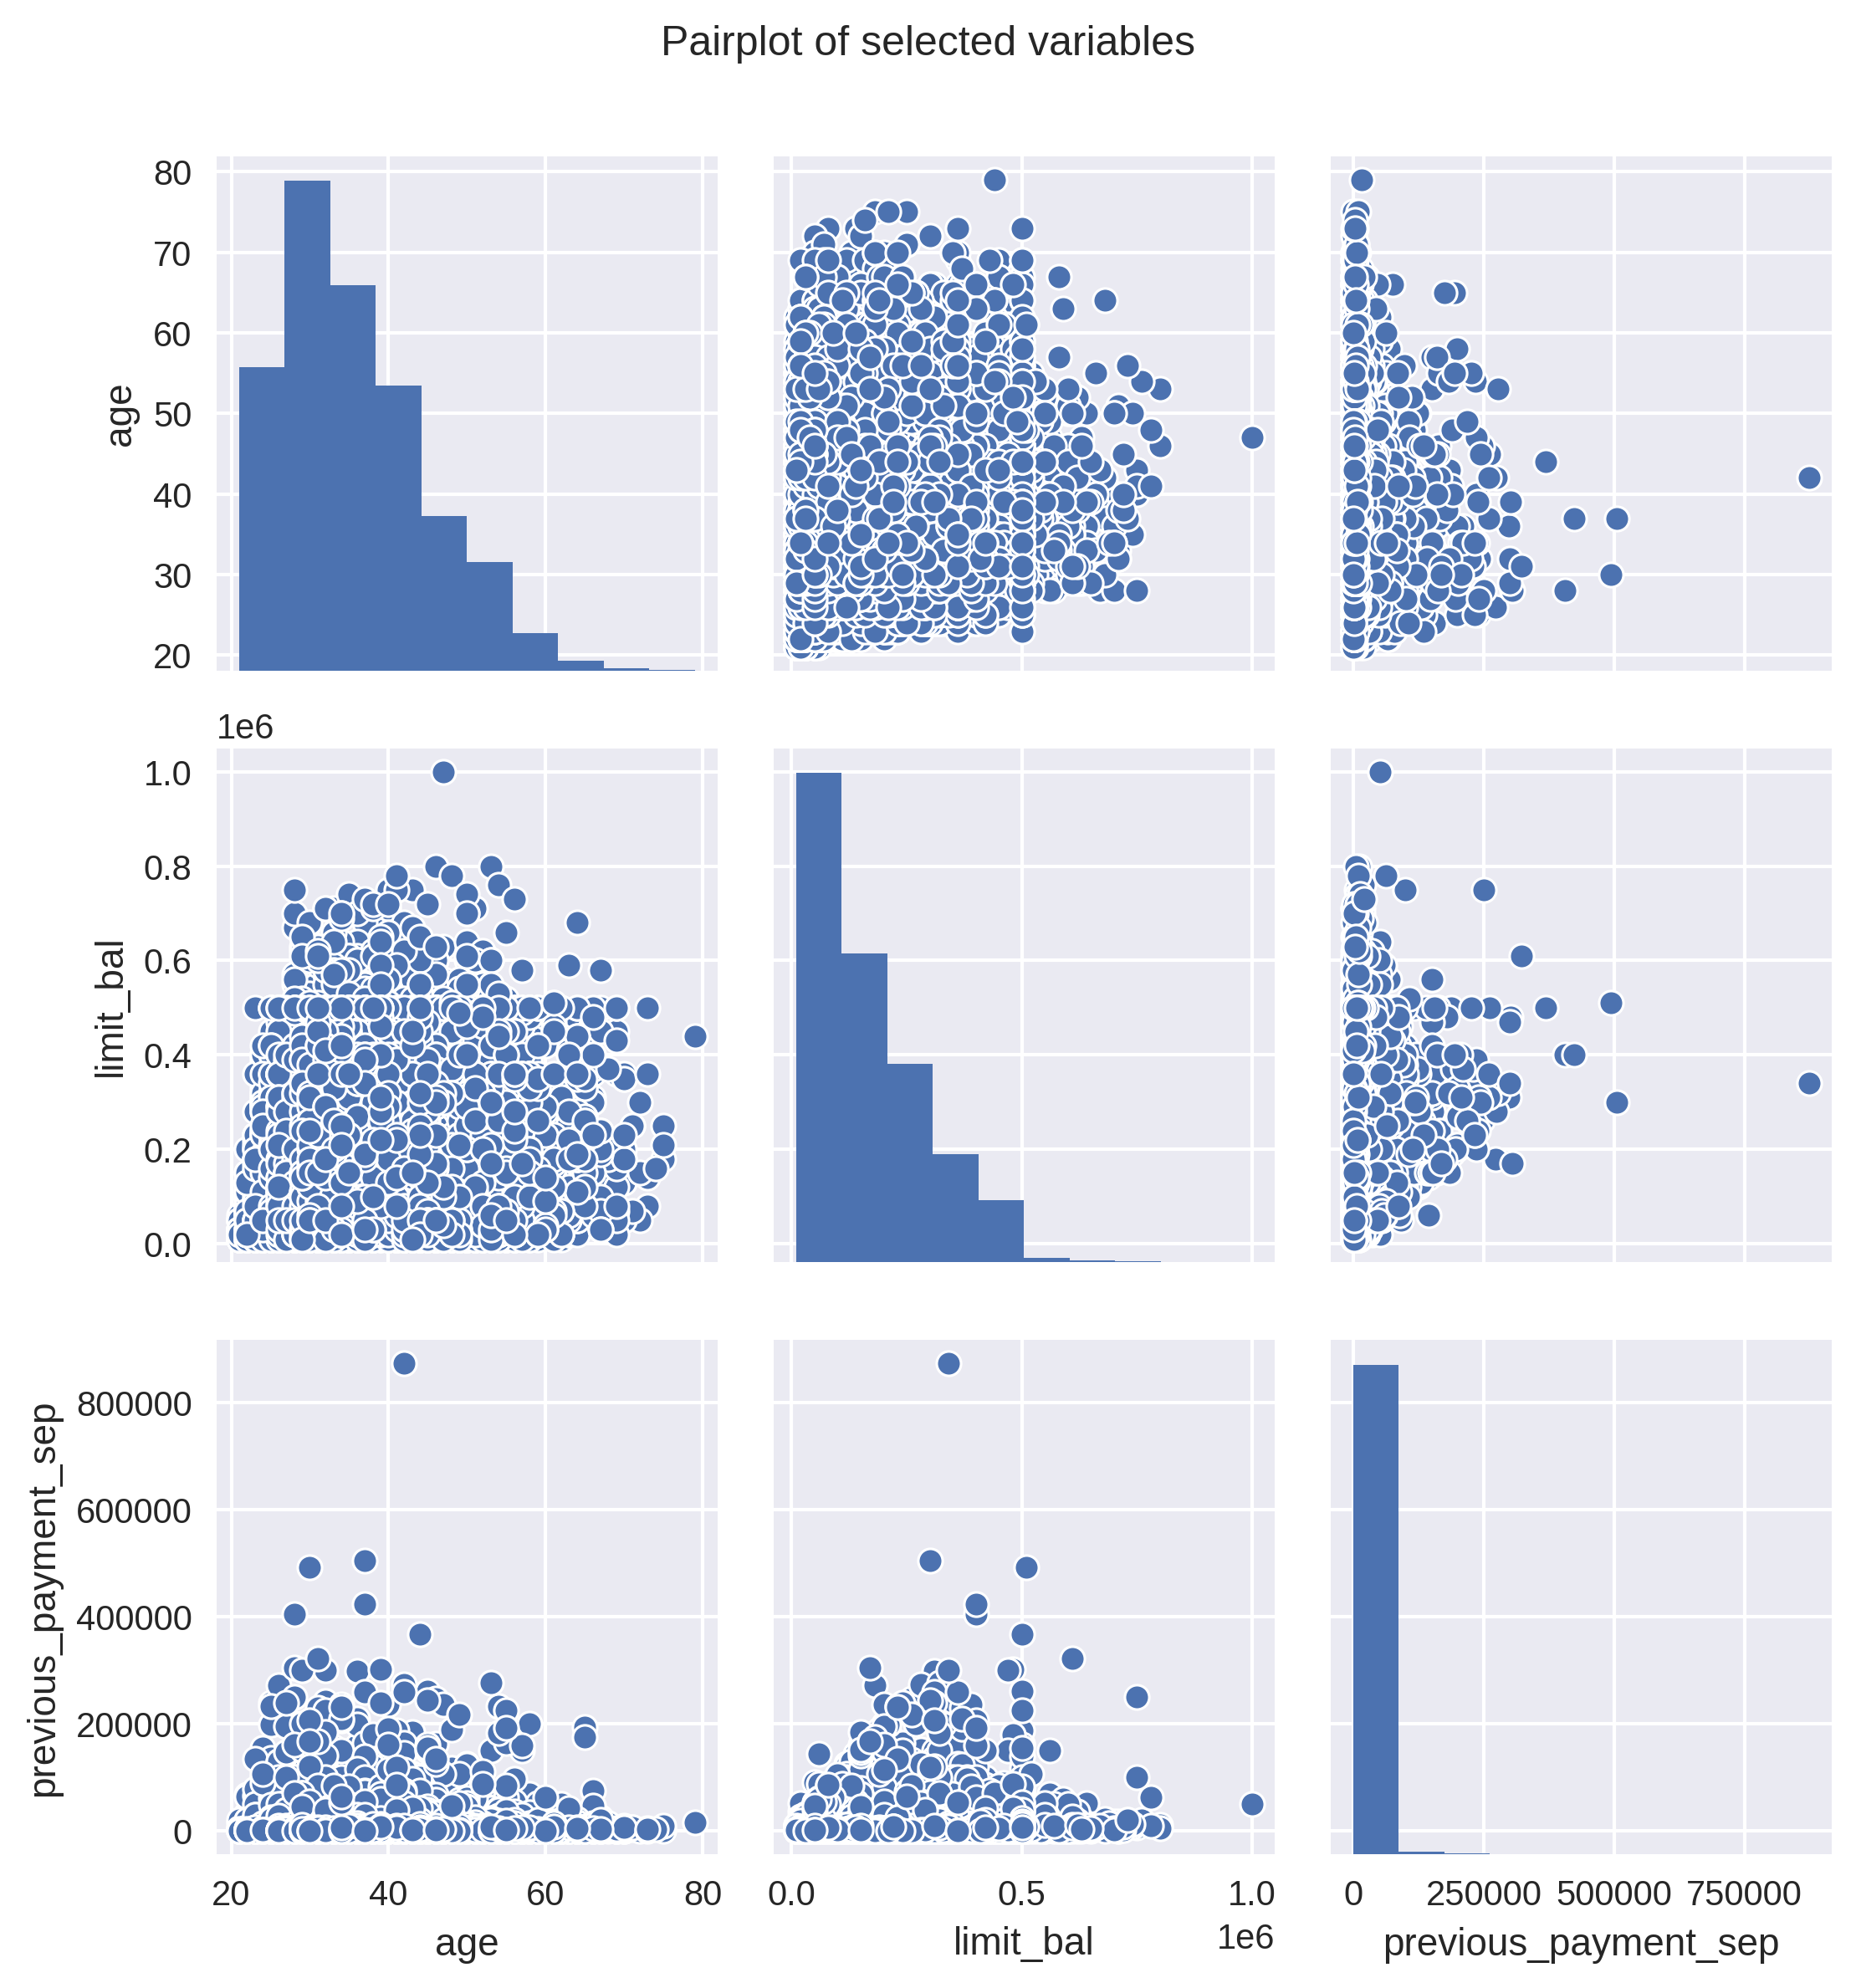

In [22]:
pair_plot = sns.pairplot(df[['age', 'limit_bal', 'previous_payment_sep']])
pair_plot.fig.suptitle('Pairplot of selected variables', y=1.05)

plt.tight_layout()
# plt.savefig('images/ch8_im6.png', bbox_inches='tight')
plt.show()

Additionally, we can separate the genders by specifying the `hue` argument:

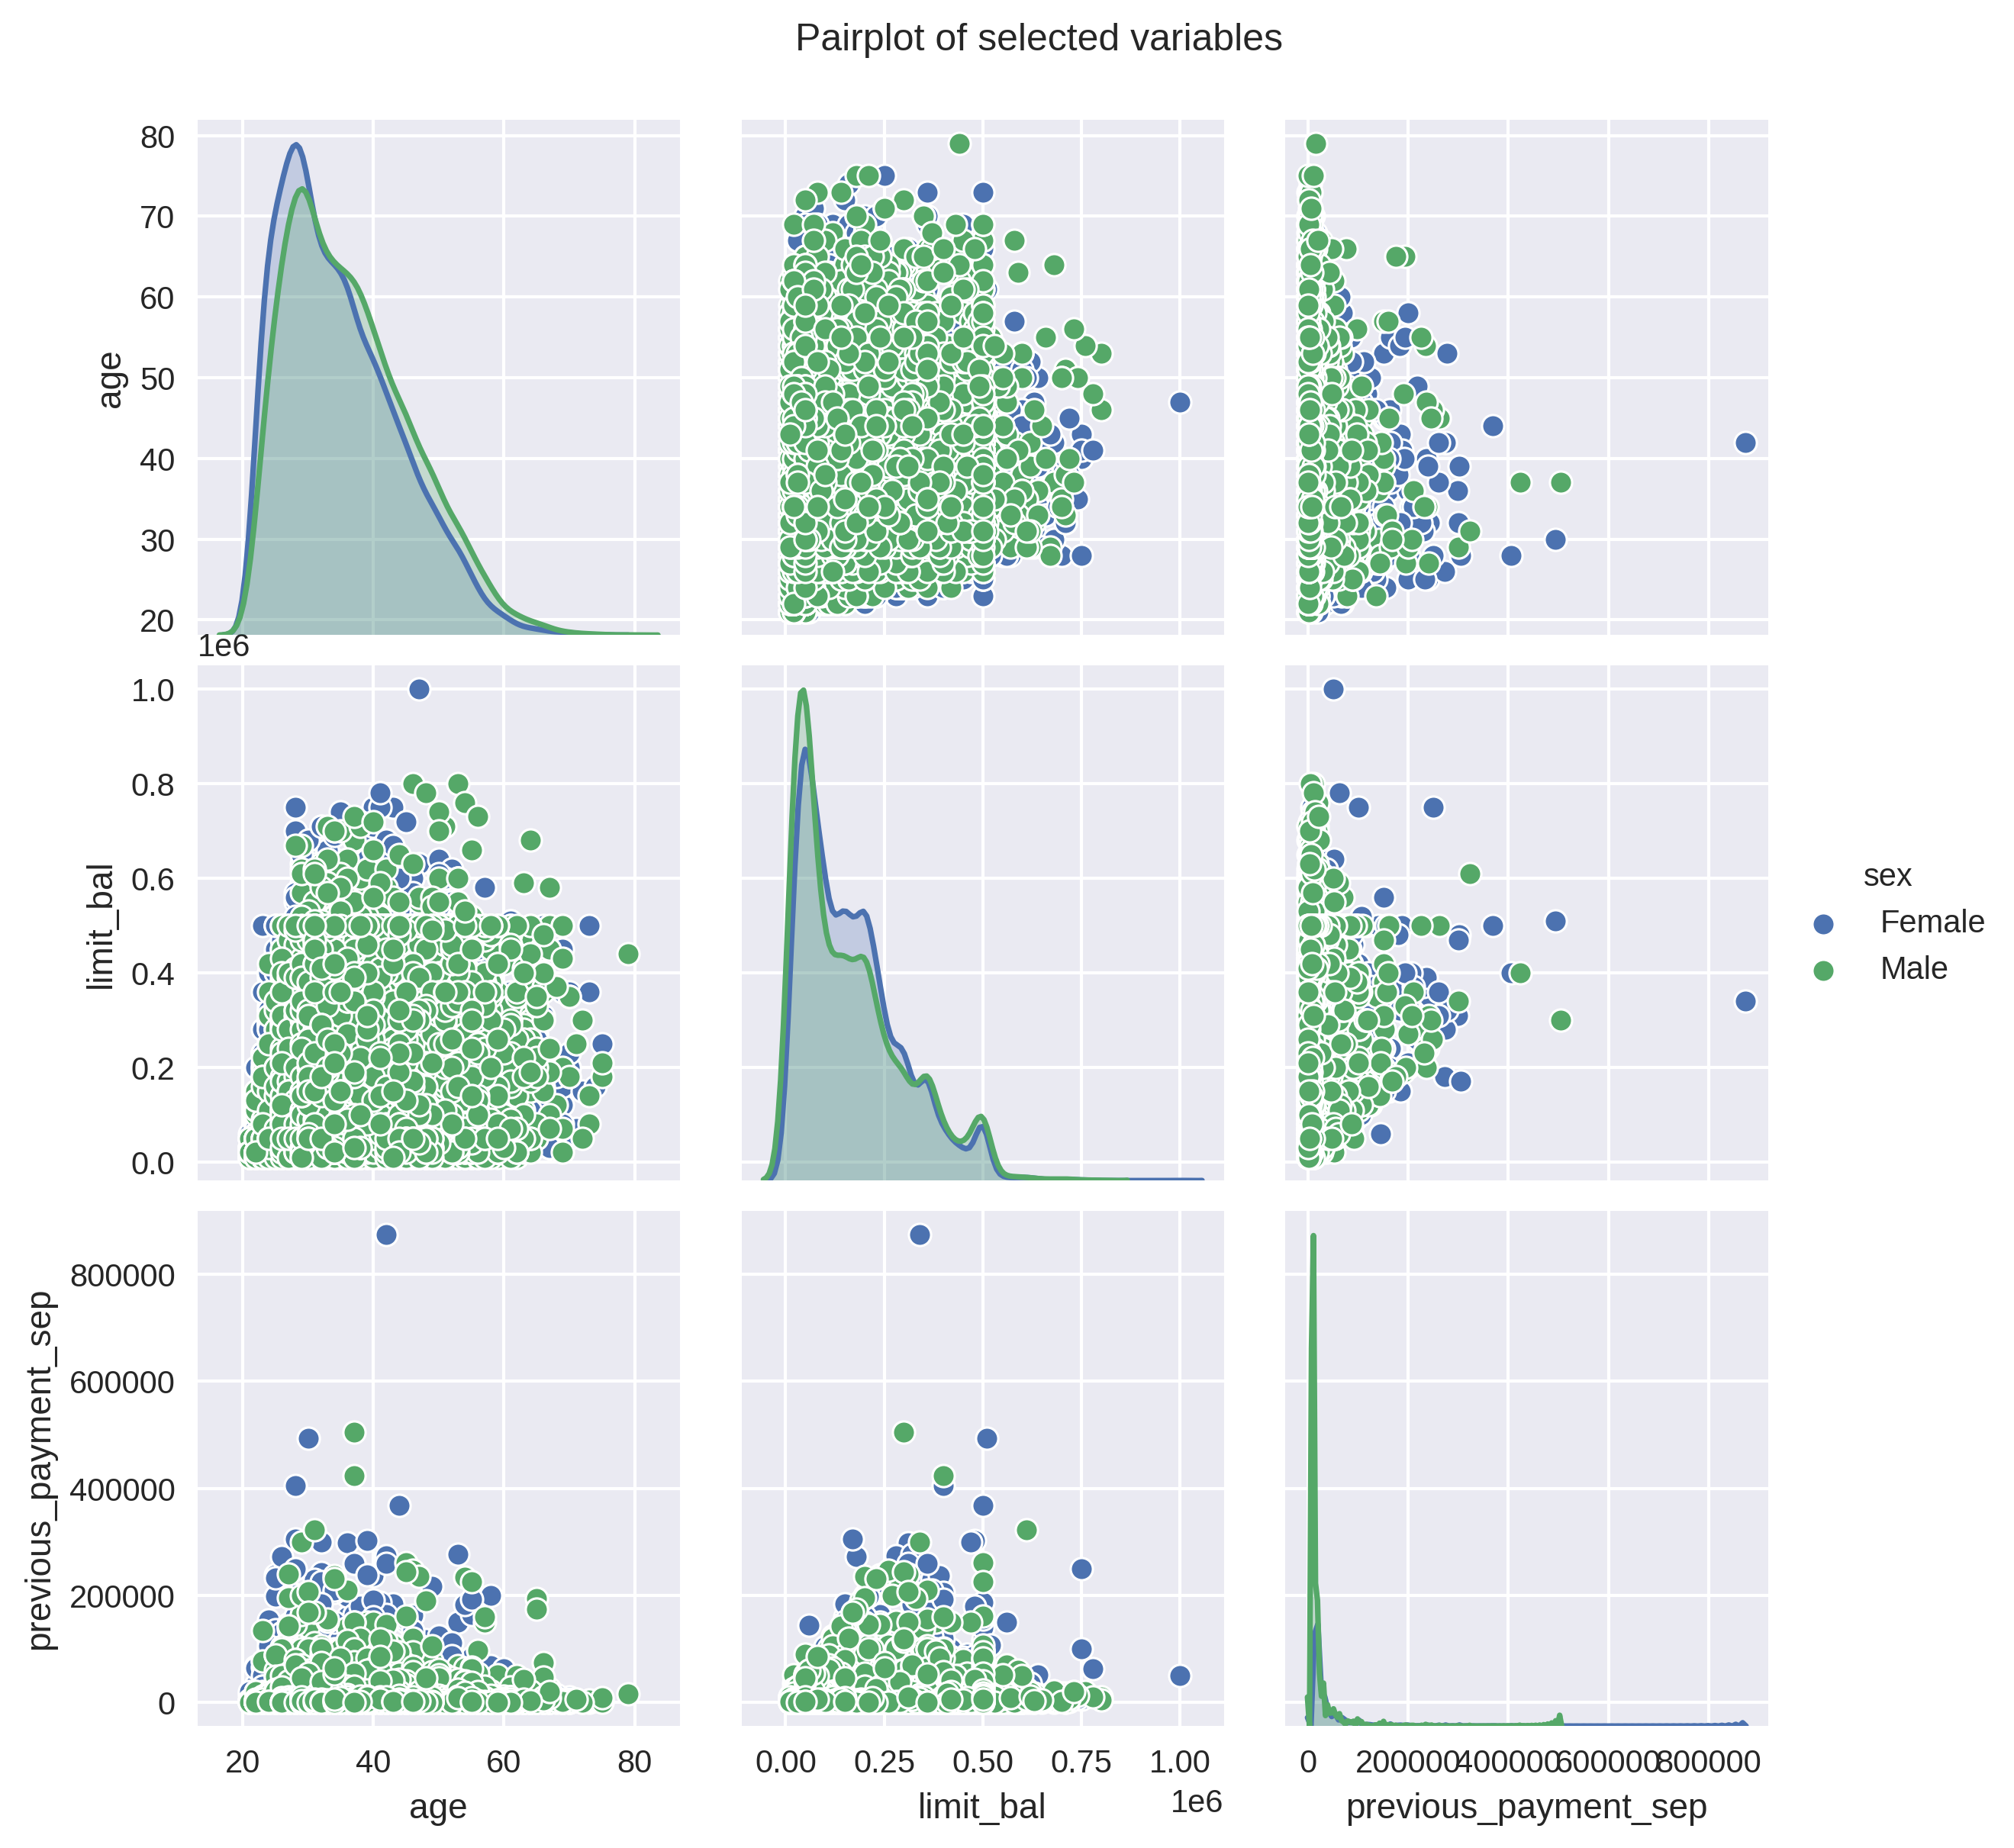

In [23]:
pair_plot = sns.pairplot(df[['sex', 'age', 'limit_bal', 'previous_payment_sep']], 
                         hue='sex')
pair_plot.fig.suptitle('Pairplot of selected variables', y=1.05);

6. Define and run a function for plotting the correlation heatmap:

In [24]:
def plot_correlation_matrix(corr_mat):
    '''
    Function for plotting the correlation heatmap. It masks the irrelevant fields.
    
    Parameters
    ----------
    corr_mat : pd.DataFrame
        Correlation matrix of the features.
    '''
    
    # temporarily change style
    sns.set(style='white')
    # mask the upper triangle
    mask = np.zeros_like(corr_mat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # set up the matplotlib figure
    fig, ax = plt.subplots()
    # set up custom diverging colormap
    cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
    # plot the heatmap
    sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, 
                cbar_kws={'shrink': .5}, ax=ax)
    ax.set_title('Correlation Matrix', fontsize=16)
    # change back to darkgrid style
    sns.set(style='darkgrid')

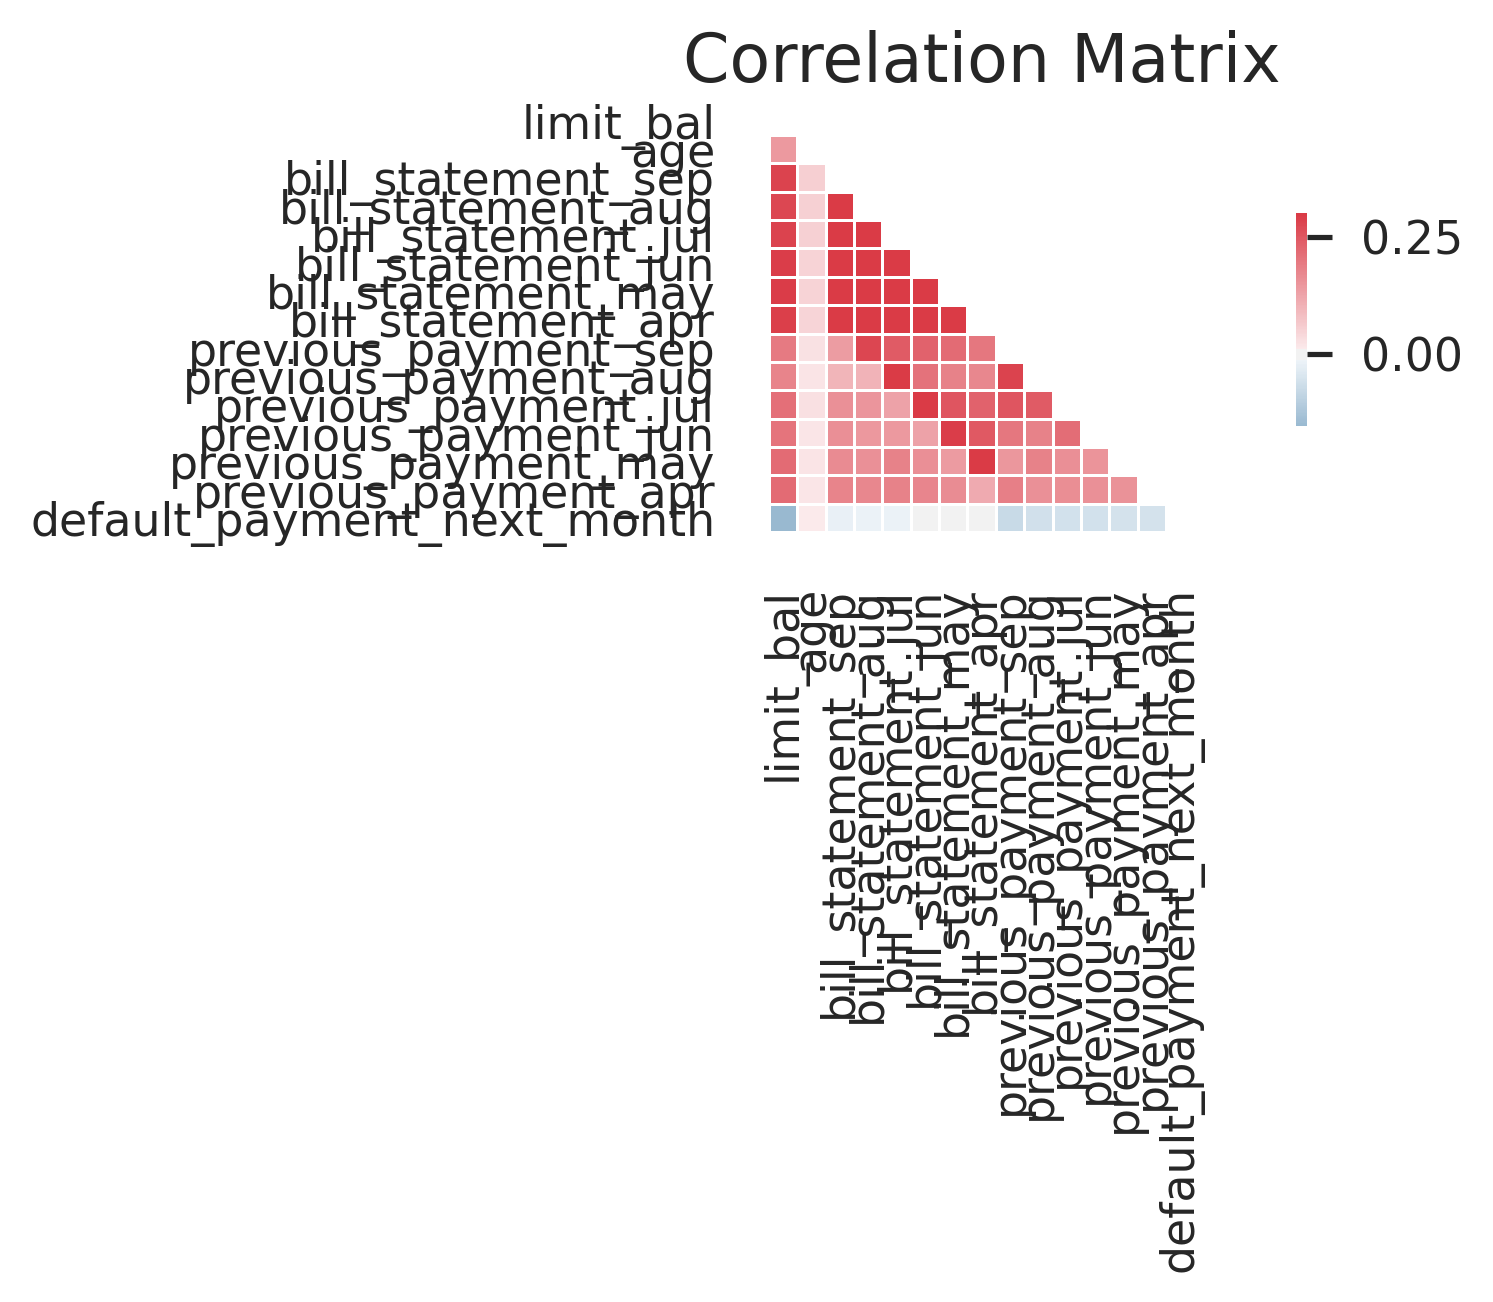

In [25]:
corr_mat = df.select_dtypes(include='number').corr()    
plot_correlation_matrix(corr_mat)

plt.tight_layout()
#plt.savefig('images/ch8_im7.png')
plt.show()

We can also directly inspect the correlation between the features (numerical) and the target:

In [30]:
df.select_dtypes(include='number').corr()[['default_payment_next_month']].sort_values(by='default_payment_next_month',ascending=False)

default_payment_next_month
default_payment_next_month                    1.000000
age                                           0.014491
bill_statement_apr                           -0.005372
bill_statement_may                           -0.006760
bill_statement_jun                           -0.010156
bill_statement_jul                           -0.014076
bill_statement_aug                           -0.014193
bill_statement_sep                           -0.019644
previous_payment_apr                         -0.053183
previous_payment_may                         -0.055124
previous_payment_jul                         -0.056250
previous_payment_jun                         -0.056827
previous_payment_aug                         -0.058579
previous_payment_sep                         -0.072929
limit_bal                                    -0.153520

7. Plot the distribution of limit balance for each gender and education level:

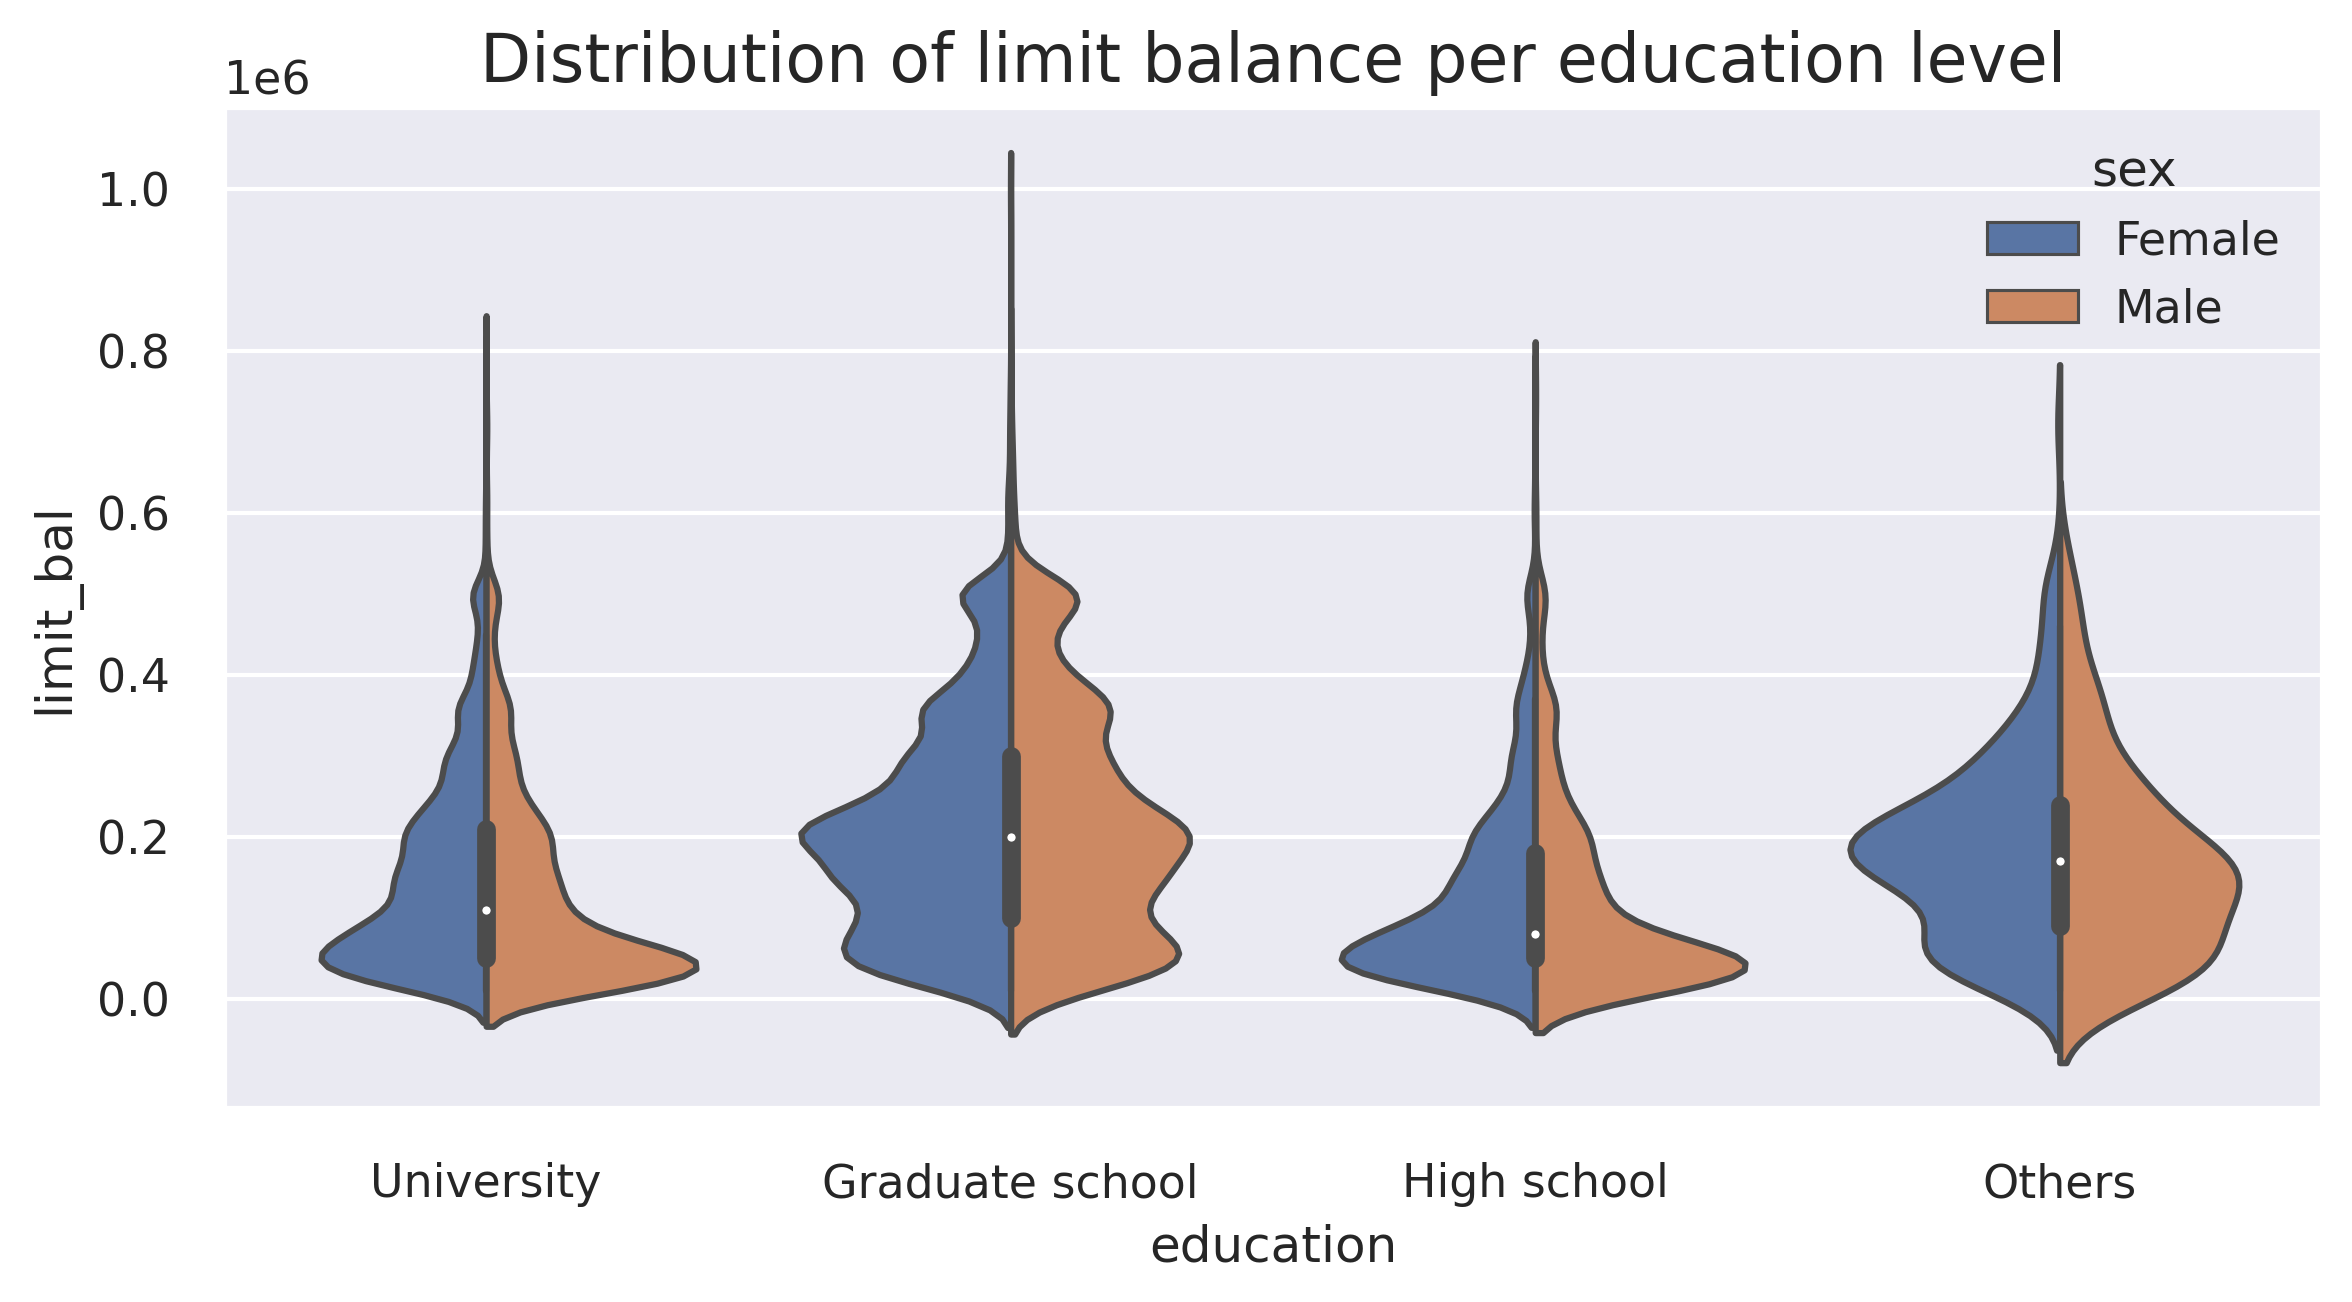

In [31]:
ax = sns.violinplot(x='education', y='limit_bal', 
                    hue='sex', split=True, data=df)
ax.set_title('Distribution of limit balance per education level', 
             fontsize=16)

plt.tight_layout()
# plt.savefig('images/ch8_im8.png')
plt.show()

The following code plots the same information, without splitting the violin plots.

In [ ]:
# ax = sns.violinplot(x='education', y='limit_bal', 
#                     hue='sex', data=df)
# ax.set_title('Distribution of limit balance per education level', 
#              fontsize=16);

8. Investigate the distribution of the target variable per gender and education level:

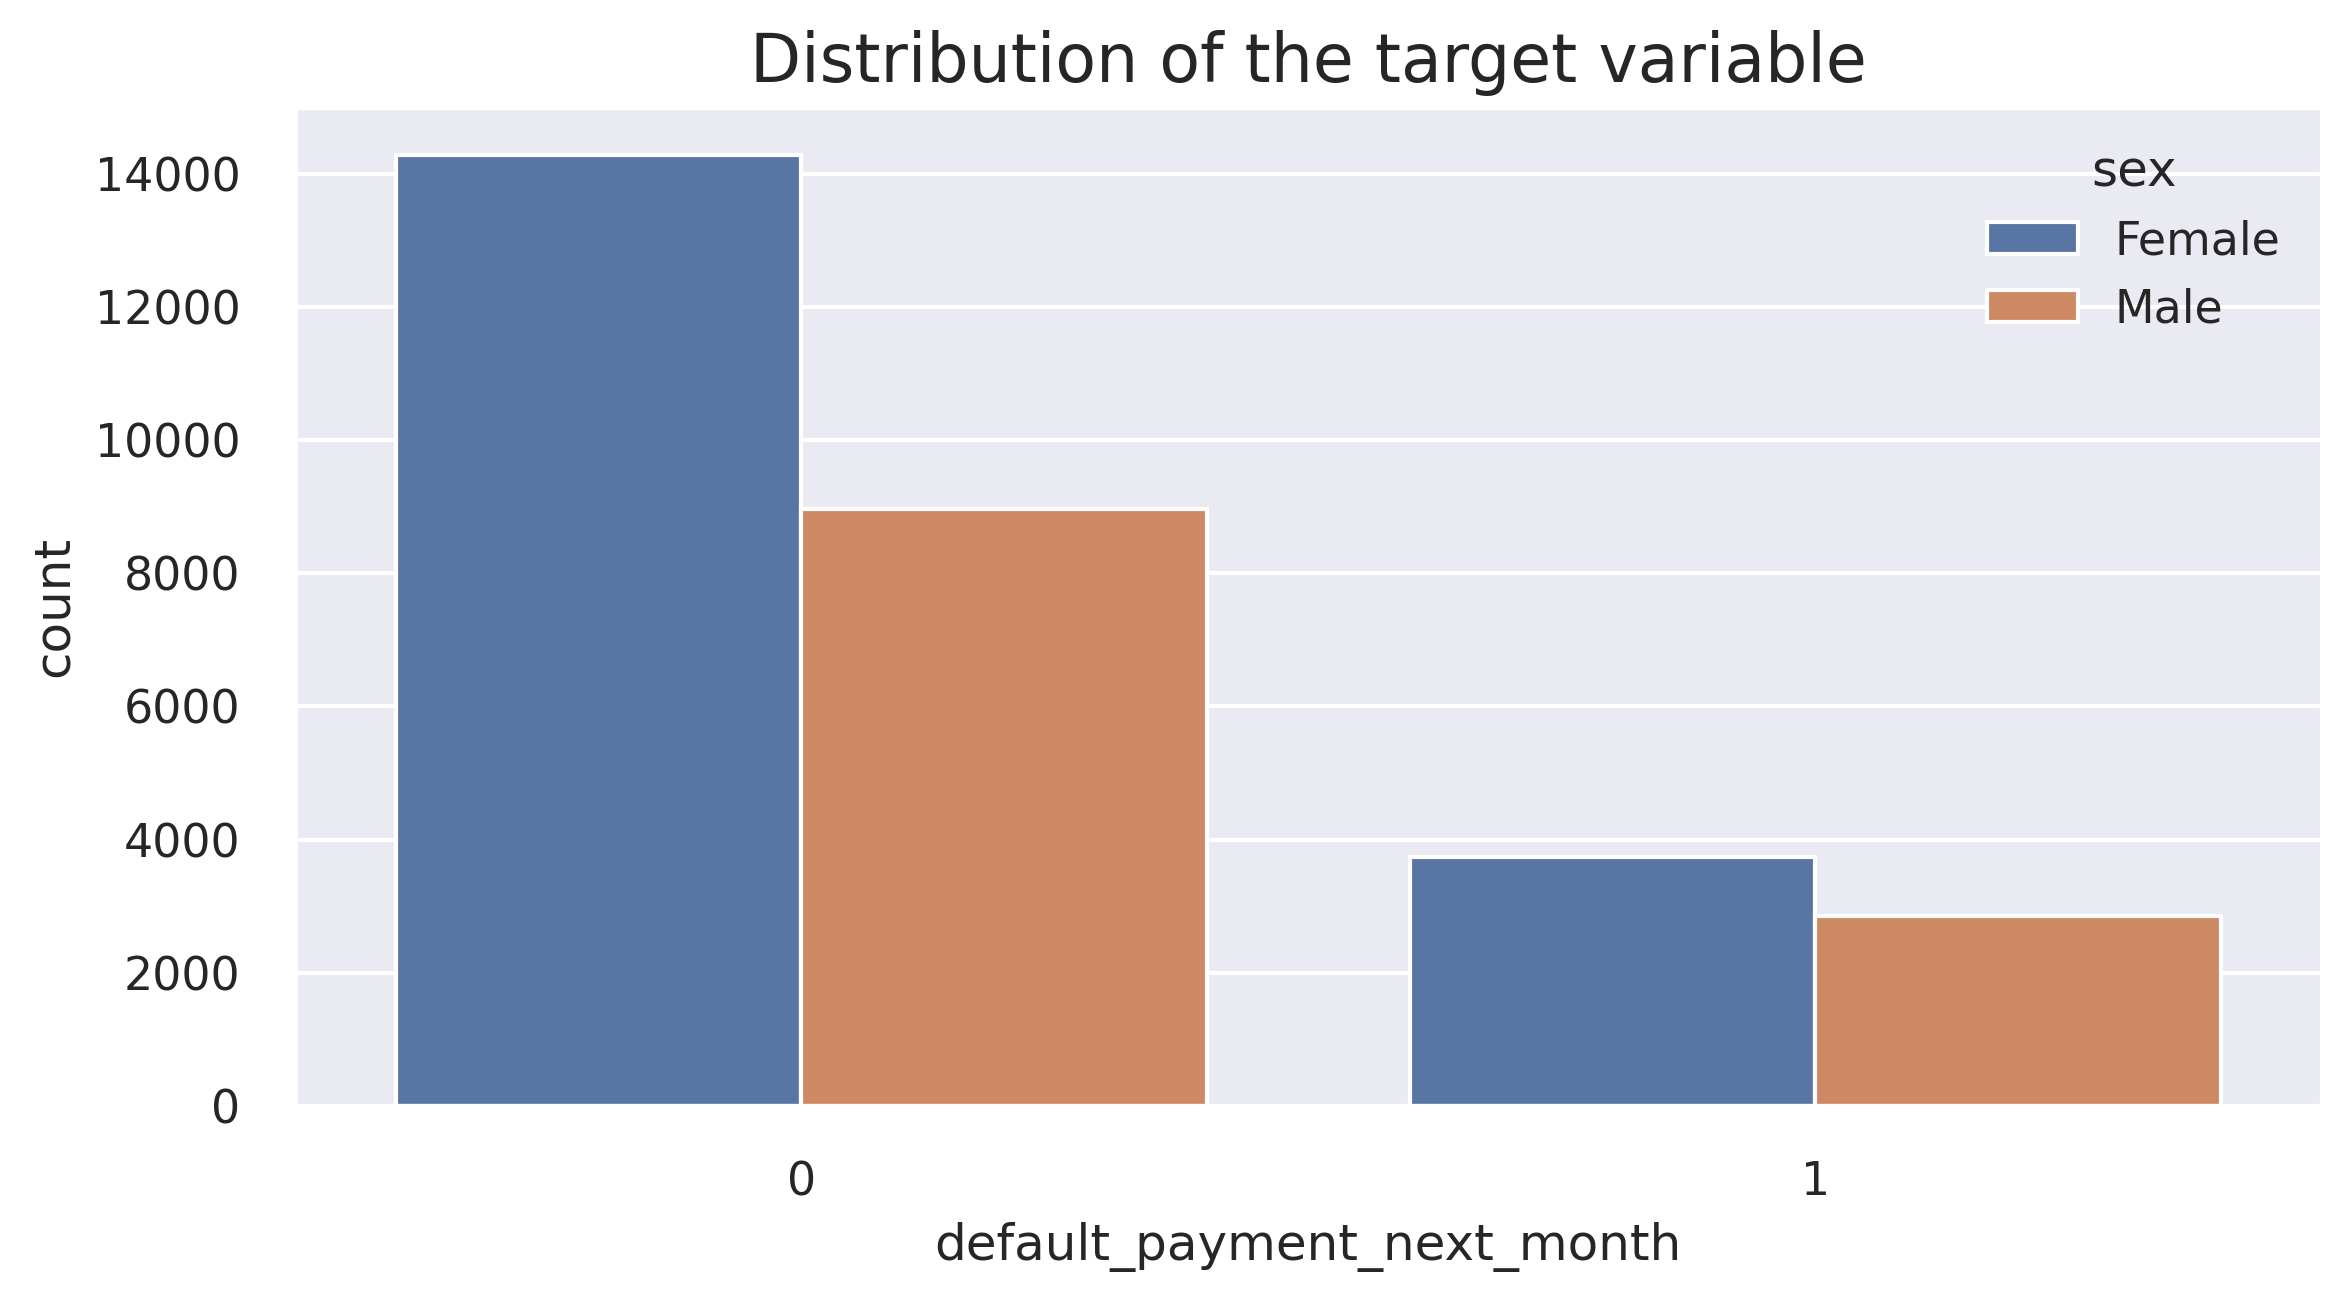

In [32]:
ax = sns.countplot('default_payment_next_month', hue='sex', 
                   data=df, orient='h')
ax.set_title('Distribution of the target variable', fontsize=16)

plt.tight_layout()
# plt.savefig('images/ch8_im9.png')
plt.show()

By analyzing the plot, we can say that the percentage of defaults is higher among
male customers.

9. Investigate the percentage of defaults per education level:

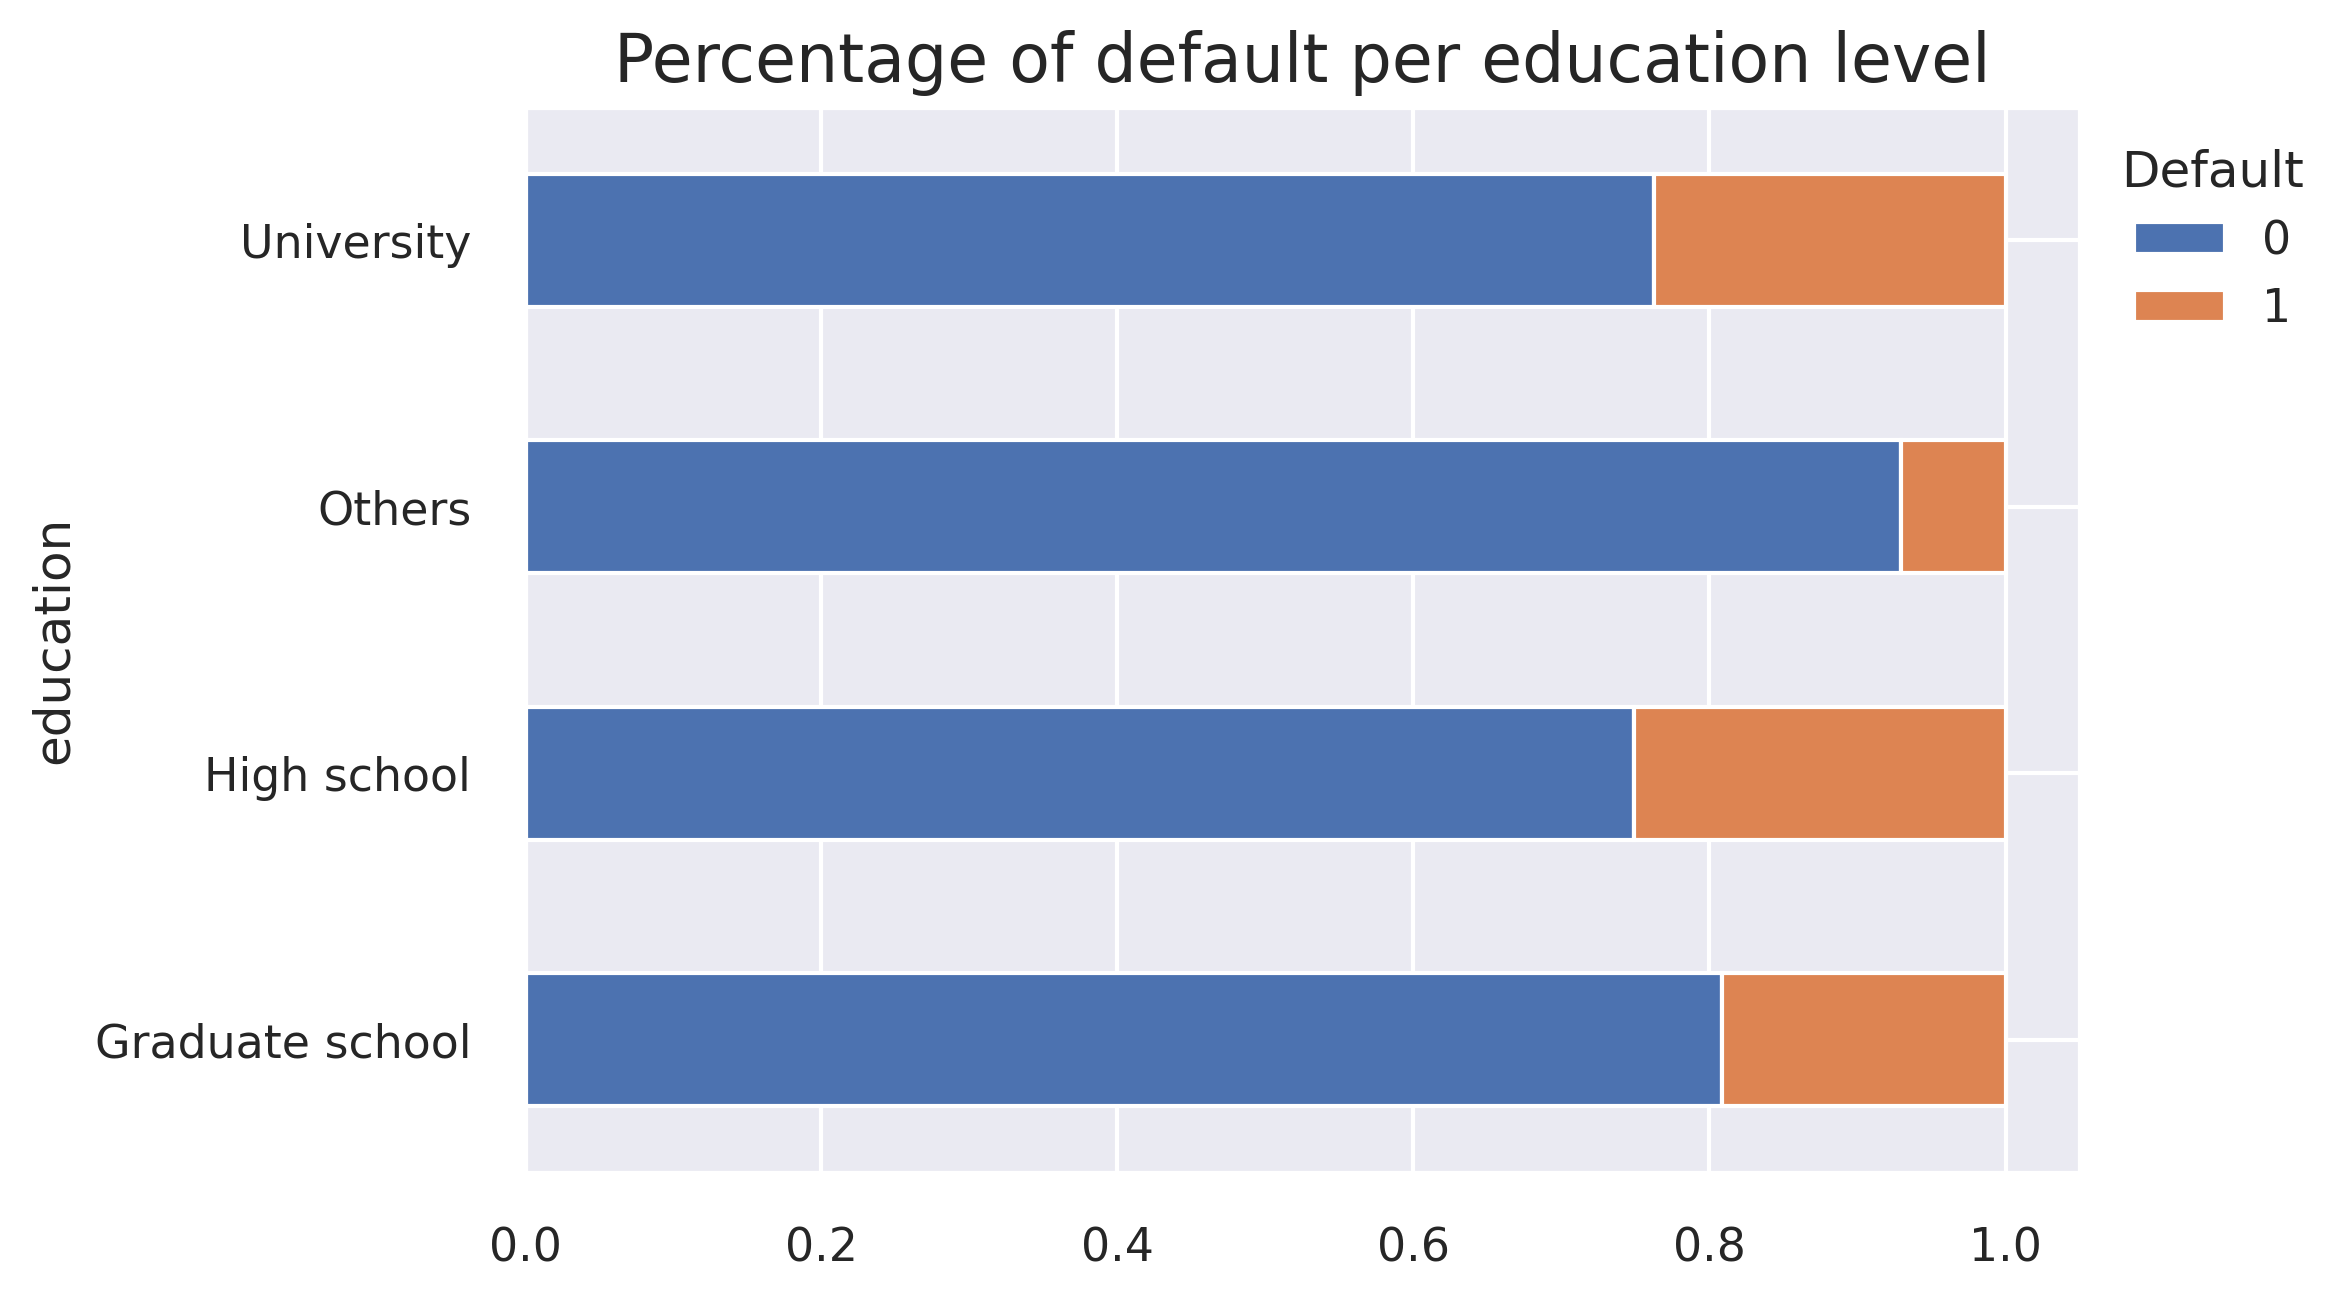

In [33]:
ax = df.groupby('education')['default_payment_next_month'] \
       .value_counts(normalize=True) \
       .unstack() \
       .plot(kind='barh', stacked='True')
ax.set_title('Percentage of default per education level', 
             fontsize=16)
ax.legend(title='Default', bbox_to_anchor=(1,1)) 

plt.tight_layout()
# plt.savefig('images/ch8_im10.png')
plt.show()

Relatively speaking, most defaults happen among customers with high-school
education, while the fewest defaults happen in the Others category.

### There's more

In [42]:
#import pandas_profiling
#from pandas_profiling import ProfileReport
#ProfileReport(df)

## Splitting the data into training and test sets

### How to do it...

1. Import the function from `sklearn`:

In [34]:
from sklearn.model_selection import train_test_split

2. Split the data into training and test sets:

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

3. Split the data into training and test sets without shuffling:

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    shuffle=False)

4. Split the data into training and test sets with stratification:

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

5. Verify that the ratio of the target is preserved:

In [43]:
y_train.value_counts(normalize=True)

0    0.778792
1    0.221208
Name: default_payment_next_month, dtype: float64

In [44]:
y_test.value_counts(normalize=True)

0    0.778833
1    0.221167
Name: default_payment_next_month, dtype: float64

### There's more

In [ ]:
# # define the size of the validation and test sets
# VALID_SIZE = 0.1
# TEST_SIZE = 0.2

# # create the initial split - training and temp
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, 
#                                                     test_size=(VALID_SIZE + TEST_SIZE), 
#                                                     stratify=y, 
#                                                     random_state=42)

# # calculate the new test size
# NEW_TEST_SIZE = np.around(TEST_SIZE / (VALID_SIZE + TEST_SIZE), 2)

# # create the valid and test sets
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, 
#                                                     test_size=NEW_TEST_SIZE, 
#                                                     stratify=y_temp, 
#                                                     random_state=42)

## Dealing with missing values

### How to do it...

1. Import the libraries:

In [45]:
import pandas as pd 
import missingno
from sklearn.impute import SimpleImputer

2. Inspect the information about the DataFrame:

In [46]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   limit_bal             30000 non-null  int64  
 1   sex                   29850 non-null  object 
 2   education             29850 non-null  object 
 3   marriage              29850 non-null  object 
 4   age                   29850 non-null  float64
 5   payment_status_sep    30000 non-null  object 
 6   payment_status_aug    30000 non-null  object 
 7   payment_status_jul    30000 non-null  object 
 8   payment_status_jun    30000 non-null  object 
 9   payment_status_may    30000 non-null  object 
 10  payment_status_apr    30000 non-null  object 
 11  bill_statement_sep    30000 non-null  int64  
 12  bill_statement_aug    30000 non-null  int64  
 13  bill_statement_jul    30000 non-null  int64  
 14  bill_statement_jun    30000 non-null  int64  
 15  bill_statement_may 

3. Visualize the nullity of the DataFrame:

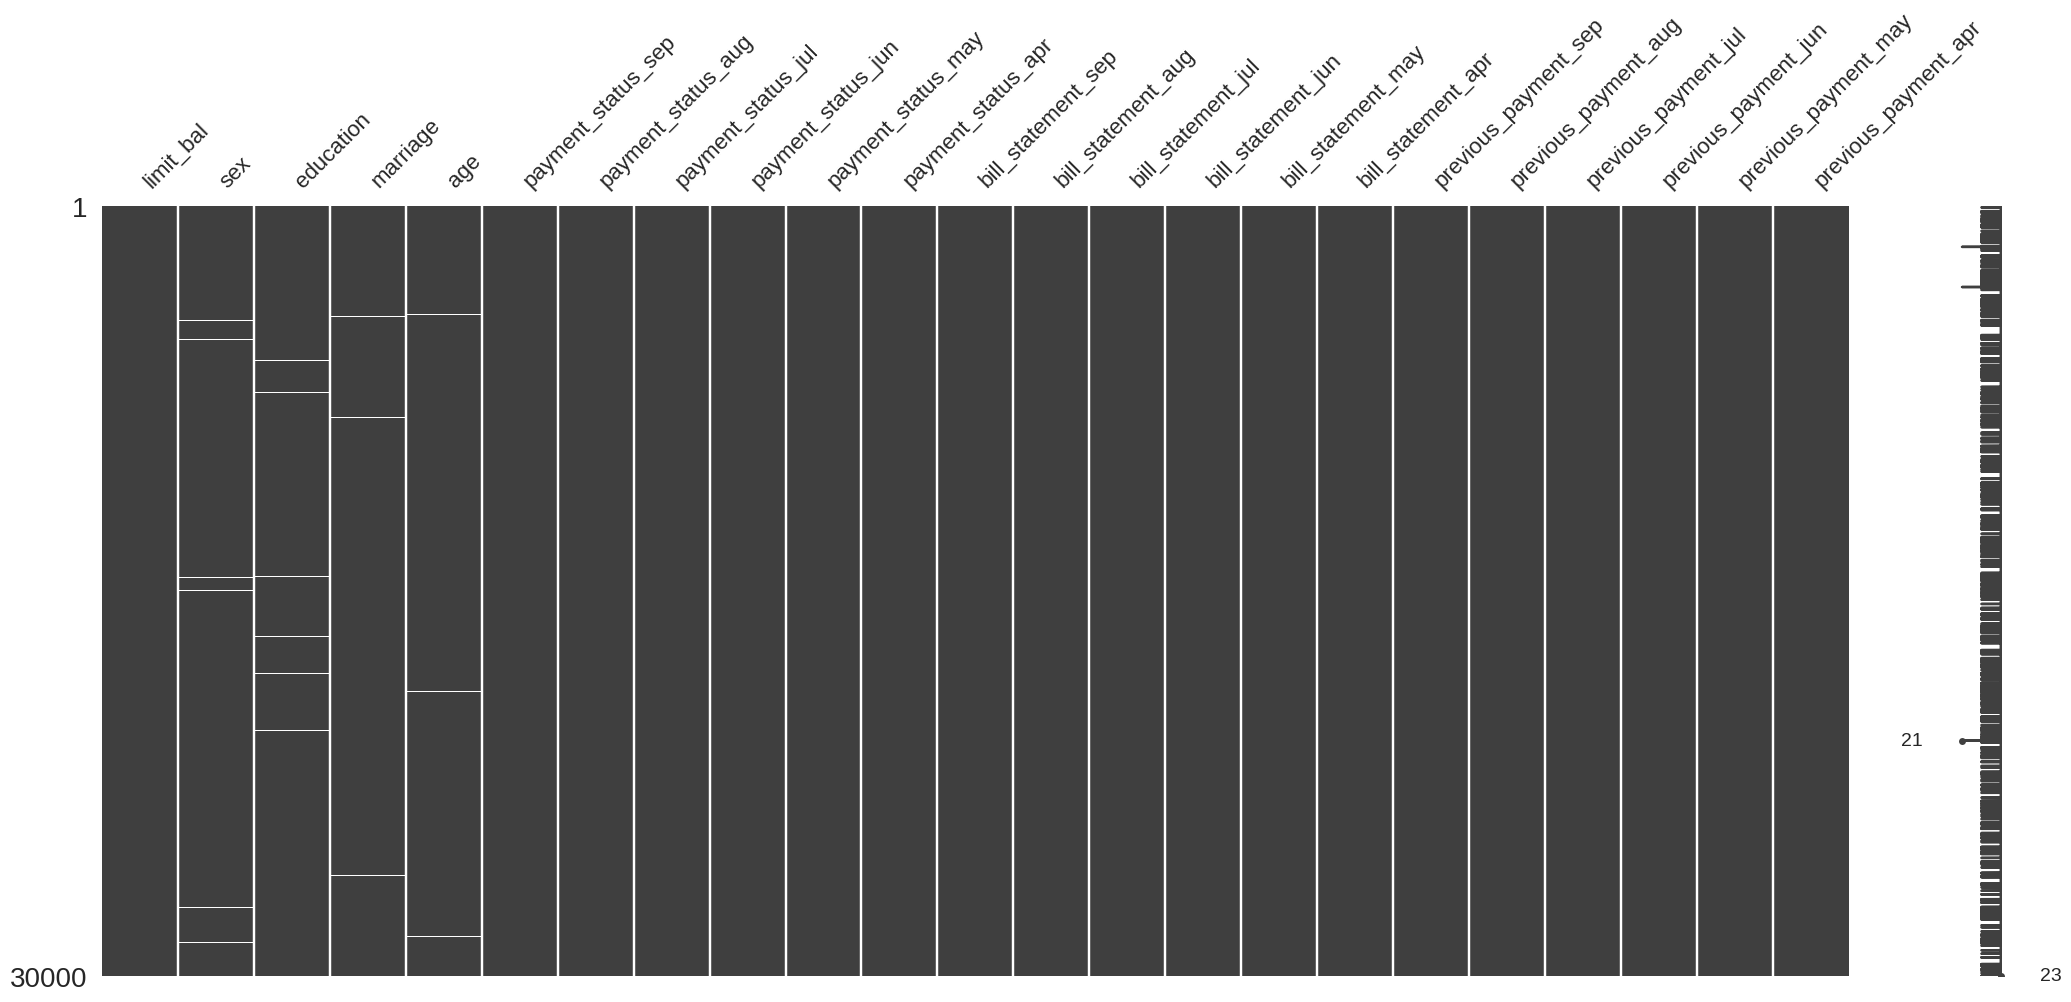

In [47]:
missingno.matrix(X)

# plt.savefig('images/ch8_im12.png')
plt.show()

4. Define columns with missing values per data type:

In [48]:
NUM_FEATURES = ['age']
CAT_FEATURES = ['sex', 'education', 'marriage']

5. Impute the numerical feature:

In [49]:
for col in NUM_FEATURES:
    num_imputer = SimpleImputer(strategy='median')
    num_imputer.fit(X_train[[col]])
    X_train.loc[:, col] = num_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = num_imputer.transform(X_test[[col]])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# alternative method using pandas

# for feature in NUM_FEATURES:
#     median_value = X_train[feature].median()
#     X_train.loc[:, feature].fillna(median_value, inplace=True)
#     X_test.loc[:, feature].fillna(median_value, inplace=True)

6. Impute the categorical features:

In [50]:
for col in CAT_FEATURES:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    cat_imputer.fit(X_train[[col]])
    X_train.loc[:, col] = cat_imputer.transform(X_train[[col]])
    X_test.loc[:, col] = cat_imputer.transform(X_test[[col]])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [ ]:
# alternative method using pandas

# for feature in CAT_FEATURES:
#     mode_value = X_train[feature].mode().values[0]
#     X_train.loc[:, feature].fillna(mode_value, inplace=True)
#     X_test.loc[:, feature].fillna(mode_value, inplace=True)

7. Verify that there are no missing values:

In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 22788 to 27126
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   limit_bal             24000 non-null  int64  
 1   sex                   24000 non-null  object 
 2   education             24000 non-null  object 
 3   marriage              24000 non-null  object 
 4   age                   24000 non-null  float64
 5   payment_status_sep    24000 non-null  object 
 6   payment_status_aug    24000 non-null  object 
 7   payment_status_jul    24000 non-null  object 
 8   payment_status_jun    24000 non-null  object 
 9   payment_status_may    24000 non-null  object 
 10  payment_status_apr    24000 non-null  object 
 11  bill_statement_sep    24000 non-null  int64  
 12  bill_statement_aug    24000 non-null  int64  
 13  bill_statement_jul    24000 non-null  int64  
 14  bill_statement_jun    24000 non-null  int64  
 15  bill_statement_

## Encoding categorical variables

### How to do it...

1. Import the libraries:

In [52]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

2. Use Label Encoder to encode a selected column:

In [54]:
X_train

limit_bal     sex  ... previous_payment_may previous_payment_apr
22788     160000  Female  ...                12300                 6100
29006     150000  Female  ...                    0                    0
16950      10000    Male  ...                  305                 1000
22280     220000  Female  ...                 4900                 6000
11346     310000  Female  ...                    0                 1200
...          ...     ...  ...                  ...                  ...
23479     100000  Female  ...                 3541                 3894
13921     120000  Female  ...                 4560                    0
3794      120000  Female  ...                 1200                 1000
27565     360000    Male  ...                    0                    0
27126     300000    Male  ...                    0                    0

[24000 rows x 23 columns]

In [55]:
COL = 'education'

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

label_enc = LabelEncoder()
label_enc.fit(X_train_copy[COL])
X_train_copy.loc[:, COL] = label_enc.transform(X_train_copy[COL])
X_test_copy.loc[:, COL] = label_enc.transform(X_test_copy[COL])

In [56]:
X_train_copy

limit_bal     sex  ...  previous_payment_may previous_payment_apr
22788     160000  Female  ...                 12300                 6100
29006     150000  Female  ...                     0                    0
16950      10000    Male  ...                   305                 1000
22280     220000  Female  ...                  4900                 6000
11346     310000  Female  ...                     0                 1200
...          ...     ...  ...                   ...                  ...
23479     100000  Female  ...                  3541                 3894
13921     120000  Female  ...                  4560                    0
3794      120000  Female  ...                  1200                 1000
27565     360000    Male  ...                     0                    0
27126     300000    Male  ...                     0                    0

[24000 rows x 23 columns]

3. Select categorical features for one-hot encoding:

In [57]:
CAT_FEATURES = X_train.select_dtypes(include='object') \
                      .columns \
                      .to_list()

4. Instantiate the One-Hot Encoder object:

In [58]:
one_hot_encoder = OneHotEncoder(sparse=False, 
                                handle_unknown='error', 
                                drop='first')

5. Create the column transformer using the one-hot encoder: 

In [59]:
one_hot_transformer = ColumnTransformer(
    [("one_hot", one_hot_encoder, CAT_FEATURES)]
    #,remainder='passthrough'
)

6. Fit the transformer:

In [61]:
one_hot_transformer.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('one_hot',
                                 OneHotEncoder(categories='auto', drop='first',
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='error',
                                               sparse=False),
                                 ['sex', 'education', 'marriage',
                                  'payment_status_sep', 'payment_status_aug',
                                  'payment_status_jul', 'payment_status_jun',
                                  'payment_status_may',
                                  'payment_status_apr'])],
                  verbose=False)

7. Apply the transformations to both training and test sets:

In [62]:
col_names = one_hot_transformer.get_feature_names()

X_train_cat = pd.DataFrame(one_hot_transformer.transform(X_train), 
                           columns=col_names, 
                           index=X_train.index)
X_train_ohe = pd.concat([X_train, X_train_cat], axis=1) \
                .drop(CAT_FEATURES, axis=1)

X_test_cat = pd.DataFrame(one_hot_transformer.transform(X_test), 
                          columns=col_names, 
                          index=X_test.index)
X_test_ohe = pd.concat([X_test, X_test_cat], axis=1) \
               .drop(CAT_FEATURES, axis=1)

In [64]:
X_train_ohe

limit_bal  ...  one_hot__x8_Unknown
22788     160000  ...                  1.0
29006     150000  ...                  1.0
16950      10000  ...                  1.0
22280     220000  ...                  1.0
11346     310000  ...                  1.0
...          ...  ...                  ...
23479     100000  ...                  1.0
13921     120000  ...                  0.0
3794      120000  ...                  1.0
27565     360000  ...                  1.0
27126     300000  ...                  1.0

[24000 rows x 72 columns]

### There's more

#### Using `pandas.get_dummies` for one-hot encoding

In [63]:
pd.get_dummies(X_train, prefix_sep='_', drop_first=True)

limit_bal  ...  payment_status_apr_Unknown
22788     160000  ...                           1
29006     150000  ...                           1
16950      10000  ...                           1
22280     220000  ...                           1
11346     310000  ...                           1
...          ...  ...                         ...
23479     100000  ...                           1
13921     120000  ...                           0
3794      120000  ...                           1
27565     360000  ...                           1
27126     300000  ...                           1

[24000 rows x 72 columns]

#### Specifying possible categories for OneHotEncoder

In [65]:
one_hot_encoder = OneHotEncoder(
    categories=[['Male', 'Female', 'Unknown']], 
    sparse=False, 
    handle_unknown='error', 
    drop='first'
)

one_hot_transformer = ColumnTransformer(
    [("one_hot", one_hot_encoder, ['sex'])]
)

one_hot_transformer.fit(X_train)
one_hot_transformer.get_feature_names()

['one_hot__x0_Female', 'one_hot__x0_Unknown']

#### Category Encoders library

In [67]:
!pip install category_encoders

     |████████████████████████████████| 81kB 2.0MB/s 


In [68]:
import category_encoders as ce

In [69]:
one_hot_encoder_ce = ce.OneHotEncoder(use_cat_names=True)

In [70]:
one_hot_encoder_ce.fit(X_train)
X_train_ce = one_hot_encoder_ce.transform(X_train)
X_train_ce.head()

limit_bal  sex_Female  ...  previous_payment_may  previous_payment_apr
22788     160000           1  ...                 12300                  6100
29006     150000           1  ...                     0                     0
16950      10000           0  ...                   305                  1000
22280     220000           1  ...                  4900                  6000
11346     310000           1  ...                     0                  1200

[5 rows x 81 columns]

In [71]:
target_encoder = ce.TargetEncoder(smoothing=0)
target_encoder.fit(X_train.sex, y_train)
target_encoder.transform(X_train.sex).head()

sex
22788  0.206563
29006  0.206563
16950  0.243825
22280  0.206563
11346  0.206563

## Fitting a decision tree classifier

### How to do it...

1. Import the libraries:

In [74]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
#from chapter_8_utils import performance_evaluation_report
from io import StringIO
import seaborn as sns
from ipywidgets import Image
import pydotplus 


In [75]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

def performance_evaluation_report(model, X_test, y_test, show_plot=False, labels=None, show_pr_curve=False):
    '''
    Function for creating a performance report of a classification model.
    
    Parameters
    ----------
    model : scikit-learn estimator
        A fitted estimator for classification problems.
    X_test : pd.DataFrame
        DataFrame with features matching y_test
    y_test : array/pd.Series
        Target of a classification problem.
    show_plot : bool
        Flag whether to show the plot
    labels : list
        List with the class names.
    show_pr_curve : bool
        Flag whether to also show the PR-curve. For this to take effect, 
        show_plot must be True.
        
    Return
    ------
    stats : pd.Series
        A series with the most important evaluation metrics
    '''

    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    cm = metrics.confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_prob)
    roc_auc = metrics.auc(fpr, tpr)

    precision, recall, thresholds = metrics.precision_recall_curve(
        y_test, y_pred_prob)
    pr_auc = metrics.auc(recall, precision)

    if show_plot:

        if labels is None:
            labels = ['Negative', 'Positive']

        N_SUBPLOTS = 3 if show_pr_curve else 2
        PLOT_WIDTH = 15 if show_pr_curve else 12
        PLOT_HEIGHT = 5 if show_pr_curve else 6

        fig, ax = plt.subplots(
            1, N_SUBPLOTS, figsize=(PLOT_WIDTH, PLOT_HEIGHT))
        fig.suptitle('Performance Evaluation', fontsize=16)

        sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='BuGn_r', square=True, cbar=False, ax=ax[0],
                    annot_kws={"ha": 'center', "va": 'center'})
        ax[0].set(xlabel='Predicted label',
                  ylabel='Actual label', title='Confusion Matrix')
        ax[0].xaxis.set_ticklabels(labels)
        ax[0].yaxis.set_ticklabels(labels)

        ax[1].plot(fpr, tpr, 'b-', label=f'ROC-AUC = {roc_auc:.2f}')
        ax[1].set(xlabel='False Positive Rate',
                  ylabel='True Positive Rate', title='ROC Curve')
        ax[1].plot(fp/(fp+tn), tp/(tp+fn), 'ro',
                   markersize=8, label='Decision Point')
        ax[1].plot([0, 1], [0, 1], 'r--')
        ax[1].legend(loc='lower right')

        if show_pr_curve:

            ax[2].plot(recall, precision, label=f'PR-AUC = {pr_auc:.2f}')
            ax[2].set(xlabel='Recall', ylabel='Precision',
                      title='Precision-Recall Curve')
            ax[2].legend()

#         print('#######################')
#         print('Evaluation metrics ####')
#         print('#######################')
#         print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred):.4f}')
#         print(f'Precision: {metrics.precision_score(y_test, y_pred):.4f}')
#         print(f'Recall (Sensitivity): {metrics.recall_score(y_test, y_pred):.4f}')
#         print(f'Specificity: {(tn / (tn + fp)):.4f}')
#         print(f'F1-Score: {metrics.f1_score(y_test, y_pred):.4f}')
#         print(f"Cohen's Kappa: {metrics.cohen_kappa_score(y_test, y_pred):.4f}")

    stats = {'accuracy': metrics.accuracy_score(y_test, y_pred),
             'precision': metrics.precision_score(y_test, y_pred),
             'recall': metrics.recall_score(y_test, y_pred),
             'specificity': (tn / (tn + fp)),
             'f1_score': metrics.f1_score(y_test, y_pred),
             'cohens_kappa': metrics.cohen_kappa_score(y_test, y_pred),
             'roc_auc': roc_auc,
             'pr_auc': pr_auc}

    return stats

2. Create the instance of the model, fit it to the training data and create prediction:

In [76]:
tree_classifier = DecisionTreeClassifier(random_state=42)
tree_classifier.fit(X_train_ohe, y_train)
y_pred = tree_classifier.predict(X_test_ohe)

3. Evaluate the results:

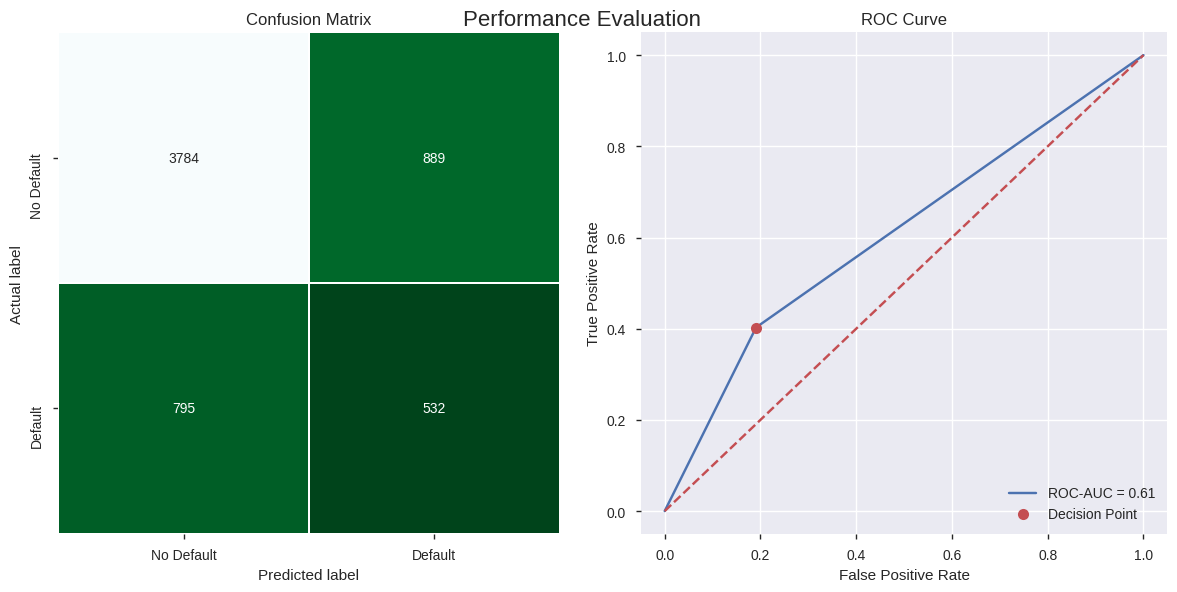

In [77]:
LABELS = ['No Default', 'Default']
tree_perf = performance_evaluation_report(tree_classifier, 
                                          X_test_ohe, 
                                          y_test, labels=LABELS, 
                                          show_plot=True)

plt.tight_layout()
# plt.savefig('images/ch8_im14.png')
plt.show()

In [78]:
tree_perf

{'accuracy': 0.7193333333333334,
 'cohens_kappa': 0.20545212086249653,
 'f1_score': 0.38719068413391555,
 'pr_auc': 0.4542470275794692,
 'precision': 0.37438423645320196,
 'recall': 0.400904295403165,
 'roc_auc': 0.6059202515178426,
 'specificity': 0.8097581853199229}

4. Plot the simplified Decision Tree:

In [79]:
small_tree = DecisionTreeClassifier(max_depth=3, 
                                    random_state=42)
small_tree.fit(X_train_ohe, y_train)

tree_dot = StringIO()
export_graphviz(small_tree, feature_names=X_train_ohe.columns,
                class_names=LABELS, rounded=True, out_file=tree_dot,
                proportion=False, precision=2, filled=True)
tree_graph = pydotplus.graph_from_dot_data(tree_dot.getvalue())  
tree_graph.set_dpi(300) 
# tree_graph.write_png('images/ch8_im15.png')
Image(value=tree_graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x15\x16\x00\x00\x07\x0c\x08\x06\x00\x00\x00|\xff\x1b…

### There's more

In [80]:
y_pred_prob = tree_classifier.predict_proba(X_test_ohe)[:, 1]

In [81]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, 
                                                               y_pred_prob)

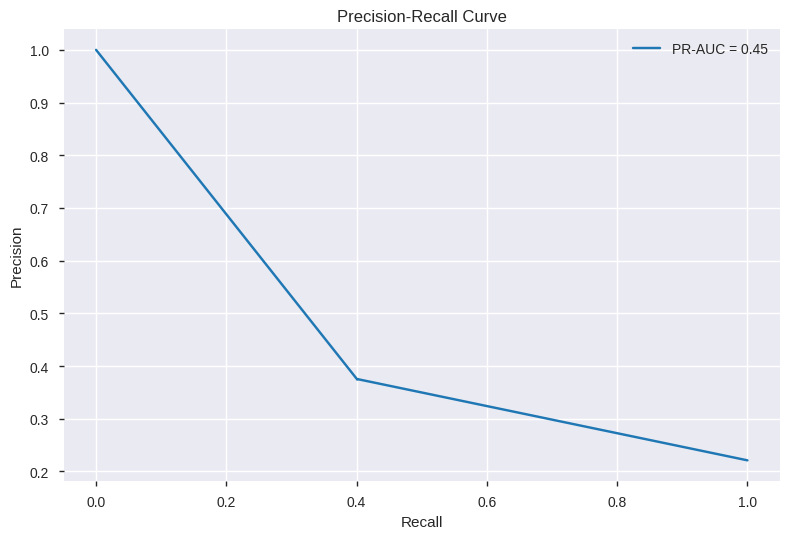

In [82]:
ax = plt.subplot()
ax.plot(recall, precision, 
        label=f'PR-AUC = {metrics.auc(recall, precision):.2f}')
ax.set(title='Precision-Recall Curve', 
       xlabel='Recall', 
       ylabel='Precision')
ax.legend()

plt.tight_layout()
# plt.savefig('images/ch8_im16.png')
plt.show()

## Implementing scikit-learn's pipelines

### How to do it...

1. Import the libraries:

In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
#from chapter_8_utils import performance_evaluation_report

2. Load the data, separate the target and create the stratified train-test split:

In [86]:
df = pd.read_csv('https://github.com/PacktPublishing/Python-for-Finance-Cookbook/blob/master/Datasets/credit_card_default.csv?raw=true', 
                 index_col=0, na_values='')

X = df.copy()
y = X.pop('default_payment_next_month')

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    stratify=y, 
                                                    random_state=42)

3. Store lists of numerical/categorical features:

In [88]:
X_train.dtypes

limit_bal                 int64
sex                      object
education                object
marriage                 object
age                     float64
payment_status_sep       object
payment_status_aug       object
payment_status_jul       object
payment_status_jun       object
payment_status_may       object
payment_status_apr       object
bill_statement_sep        int64
bill_statement_aug        int64
bill_statement_jul        int64
bill_statement_jun        int64
bill_statement_may        int64
bill_statement_apr        int64
previous_payment_sep      int64
previous_payment_aug      int64
previous_payment_jul      int64
previous_payment_jun      int64
previous_payment_may      int64
previous_payment_apr      int64
dtype: object

In [87]:
num_features = X_train.select_dtypes(include='number') \
                      .columns \
                      .to_list()
cat_features = X_train.select_dtypes(include='object') \
                      .columns \
                      .to_list()

4. Define the numerical pipeline:

In [89]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

5. Define the categorical pipeline:

In [90]:
cat_list = [list(X_train[col].dropna().unique()) for col in cat_features]
cat_list

[['Female', 'Male'],
 ['University', 'Graduate school', 'High school', 'Others'],
 ['Single', 'Married', 'Others'],
 ['Payment delayed 2 months',
  'Payment delayed 1 month',
  'Unknown',
  'Payed duly',
  'Payment delayed 3 months',
  'Payment delayed 4 months',
  'Payment delayed 6 months',
  'Payment delayed 5 months',
  'Payment delayed 8 months',
  'Payment delayed 7 months'],
 ['Payment delayed 2 months',
  'Payed duly',
  'Unknown',
  'Payment delayed 3 months',
  'Payment delayed 1 month',
  'Payment delayed 4 months',
  'Payment delayed 5 months',
  'Payment delayed 7 months',
  'Payment delayed 6 months',
  'Payment delayed 8 months'],
 ['Payment delayed 3 months',
  'Payed duly',
  'Unknown',
  'Payment delayed 2 months',
  'Payment delayed 4 months',
  'Payment delayed 7 months',
  'Payment delayed 6 months',
  'Payment delayed 5 months',
  'Payment delayed 1 month',
  'Payment delayed 8 months'],
 ['Payment delayed 2 months',
  'Unknown',
  'Payed duly',
  'Payment delayed

In [91]:
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(categories=cat_list, sparse=False, 
                             handle_unknown='error', drop='first'))
])

6. Define the column transformer object:

In [92]:
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_features),
    ('categorical', cat_pipeline, cat_features)],
    remainder='drop')

7. Create the joint pipeline:

In [93]:
dec_tree = DecisionTreeClassifier(random_state=42)

tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', dec_tree)])

8. Fit the pipeline to the data:

In [94]:
tree_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numerical',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                       

9. Evaluate the performance of the entire pipeline:

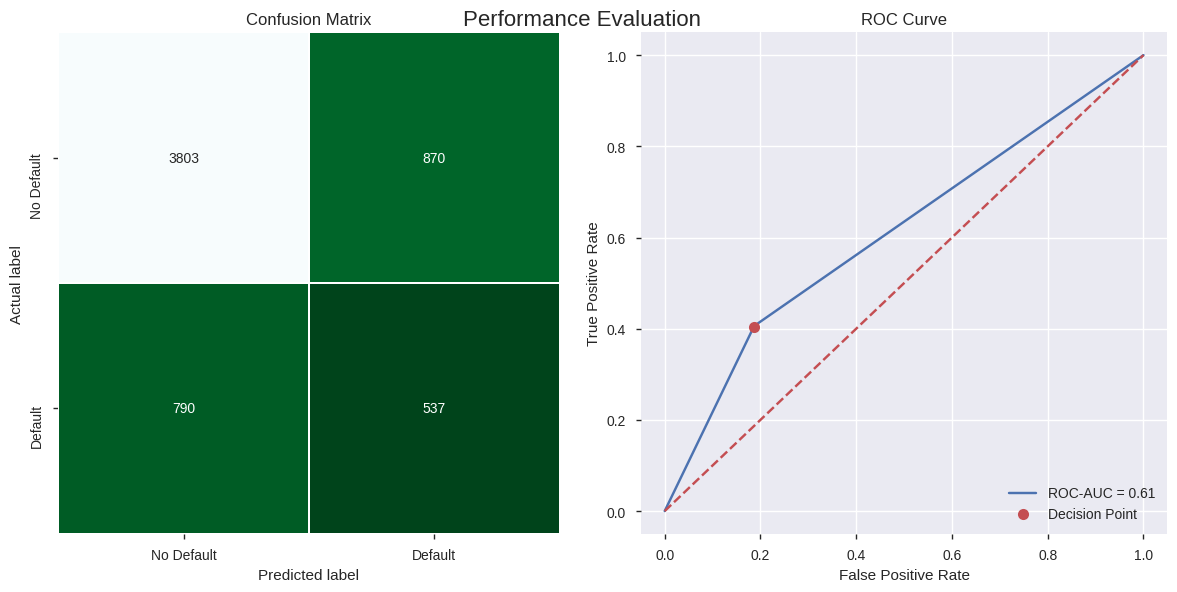

In [95]:
LABELS = ['No Default', 'Default']
tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True)

plt.tight_layout()
# plt.savefig('images/ch8_im17.png')
plt.show()

In [96]:
tree_perf

{'accuracy': 0.7233333333333334,
 'cohens_kappa': 0.21388003714653614,
 'f1_score': 0.3928310168251646,
 'pr_auc': 0.4589251149708047,
 'precision': 0.3816631130063966,
 'recall': 0.4046721929163527,
 'roc_auc': 0.6095279347712678,
 'specificity': 0.8138240958698909}

### There's more

1. Import the base estimator and transformer from `sklearn`:

In [97]:
from sklearn.base import BaseEstimator, TransformerMixin

2. Define the `OutlierRemover` class:

In [98]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, n_std=3):
        self.n_std = n_std
    
    def fit(self, X, y = None):
        if np.isnan(X).any(axis=None):
            raise ValueError('''There are missing values in the array! 
                                Please remove them.''')

        mean_vec = np.mean(X, axis=0)
        std_vec = np.std(X, axis=0)
        
        self.upper_band_ = mean_vec + self.n_std * std_vec
        self.lower_band_ = mean_vec - self.n_std * std_vec
        self.n_features_ = len(self.upper_band_)
        
        return self 
    
    def transform(self, X, y = None):
        X_copy = pd.DataFrame(X.copy())
        
        upper_band = np.repeat(
            self.upper_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        lower_band = np.repeat(
            self.lower_band_.reshape(self.n_features_, -1), 
            len(X_copy), 
            axis=1).transpose()
        
        X_copy[X_copy >= upper_band] = upper_band
        X_copy[X_copy <= lower_band] = lower_band
        
        return X_copy.values

3. Add the `OutlierRemover` to the numerical Pipeline:

In [99]:
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('outliers', OutlierRemover())
])

4. Run the rest of the Pipeline, to compare the results:

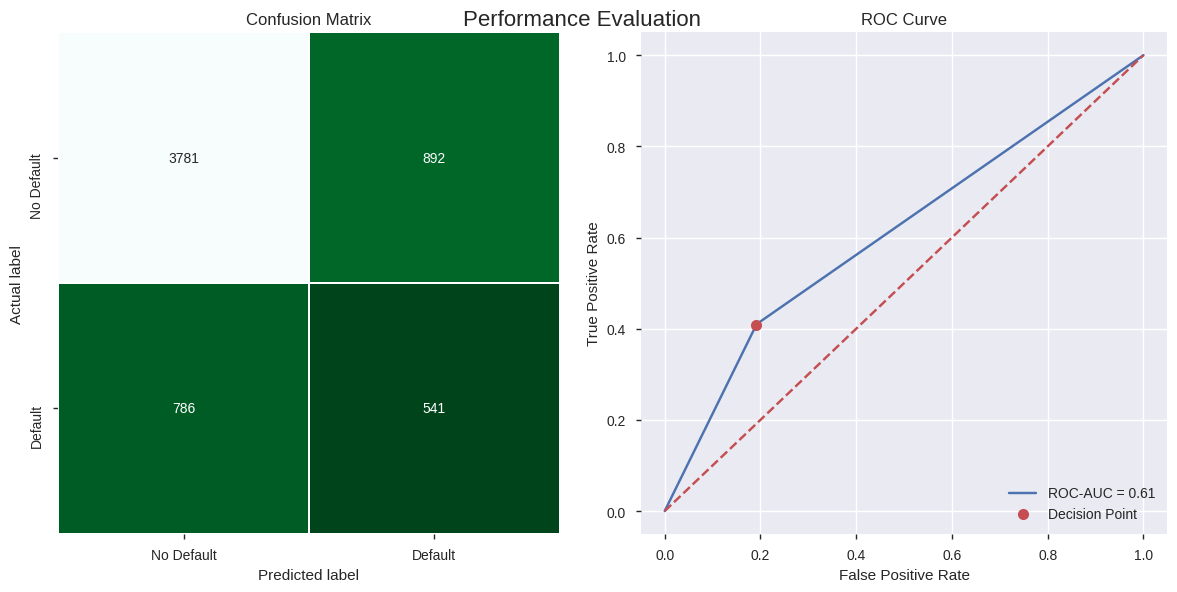

In [100]:
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_features),
    ('categorical', cat_pipeline, cat_features)],
    remainder='drop')

dec_tree = DecisionTreeClassifier(random_state=42)

tree_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('classifier', dec_tree)])

tree_pipeline.fit(X_train, y_train)

tree_perf = performance_evaluation_report(tree_pipeline, X_test, 
                                          y_test, labels=LABELS, 
                                          show_plot=True)

plt.tight_layout()
# plt.savefig('images/ch8_im18.png')
plt.show()

In [101]:
tree_perf

{'accuracy': 0.7203333333333334,
 'cohens_kappa': 0.21077497538963086,
 'f1_score': 0.39202898550724635,
 'pr_auc': 0.4582134167657523,
 'precision': 0.377529658060014,
 'recall': 0.4076865109269028,
 'roc_auc': 0.608982787005664,
 'specificity': 0.8091161994436122}

## Tuning hyperparameters using grid search and cross-validation

### How to do it...

1. Import the libraries:

In [102]:
from sklearn.model_selection import (GridSearchCV, cross_val_score, 
                                     RandomizedSearchCV, cross_validate, 
                                     StratifiedKFold)
from sklearn import metrics

2. Define the cross-validation scheme:

In [103]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=42)

3. Evaluate the pipeline using cross-validation:

In [104]:
cross_val_score(tree_pipeline, X_train, y_train, cv=k_fold)

array([0.72333333, 0.72958333, 0.71375   , 0.723125  , 0.72      ])

4. Add extra metrics to cross-validation:

In [105]:
cross_validate(tree_pipeline, X_train, y_train, cv=k_fold, 
               scoring=['accuracy', 'precision', 'recall', 
                        'roc_auc'])

{'fit_time': array([1.11911798, 1.08600569, 1.08452964, 1.1125617 , 1.08337426]),
 'score_time': array([0.07236958, 0.07217026, 0.07296252, 0.07160807, 0.0715313 ]),
 'test_accuracy': array([0.72333333, 0.72958333, 0.71375   , 0.723125  , 0.72      ]),
 'test_precision': array([0.38560411, 0.39557522, 0.36978297, 0.38638298, 0.37674825]),
 'test_recall': array([0.42412818, 0.42090395, 0.41713748, 0.42749529, 0.40583804]),
 'test_roc_auc': array([0.61633282, 0.61893804, 0.60794039, 0.61806569, 0.60712913])}

5. Define the parameter grid:

In [106]:
param_grid = {'classifier__criterion': ['entropy', 'gini'],
              'classifier__max_depth': range(3, 11),
              'classifier__min_samples_leaf': range(2, 11), 
              'preprocessor__numerical__outliers__n_std': [3, 4]}

6. Run Grid Search:

In [ ]:
classifier_gs = GridSearchCV(tree_pipeline, param_grid, scoring='recall', 
                             cv=k_fold, n_jobs=-1, verbose=1)

classifier_gs.fit(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min


In [ ]:
print(f'Best parameters: {classifier_gs.best_params_}') 
print(f'Recall (Training set): {classifier_gs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, classifier_gs.predict(X_test)):.4f}')

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3, 'preprocessor__numerical__outliers__n_std': 3}
Recall (Training set): 0.3905
Recall (Test set): 0.3828


7. Evaluate the performance of the Grid Search:

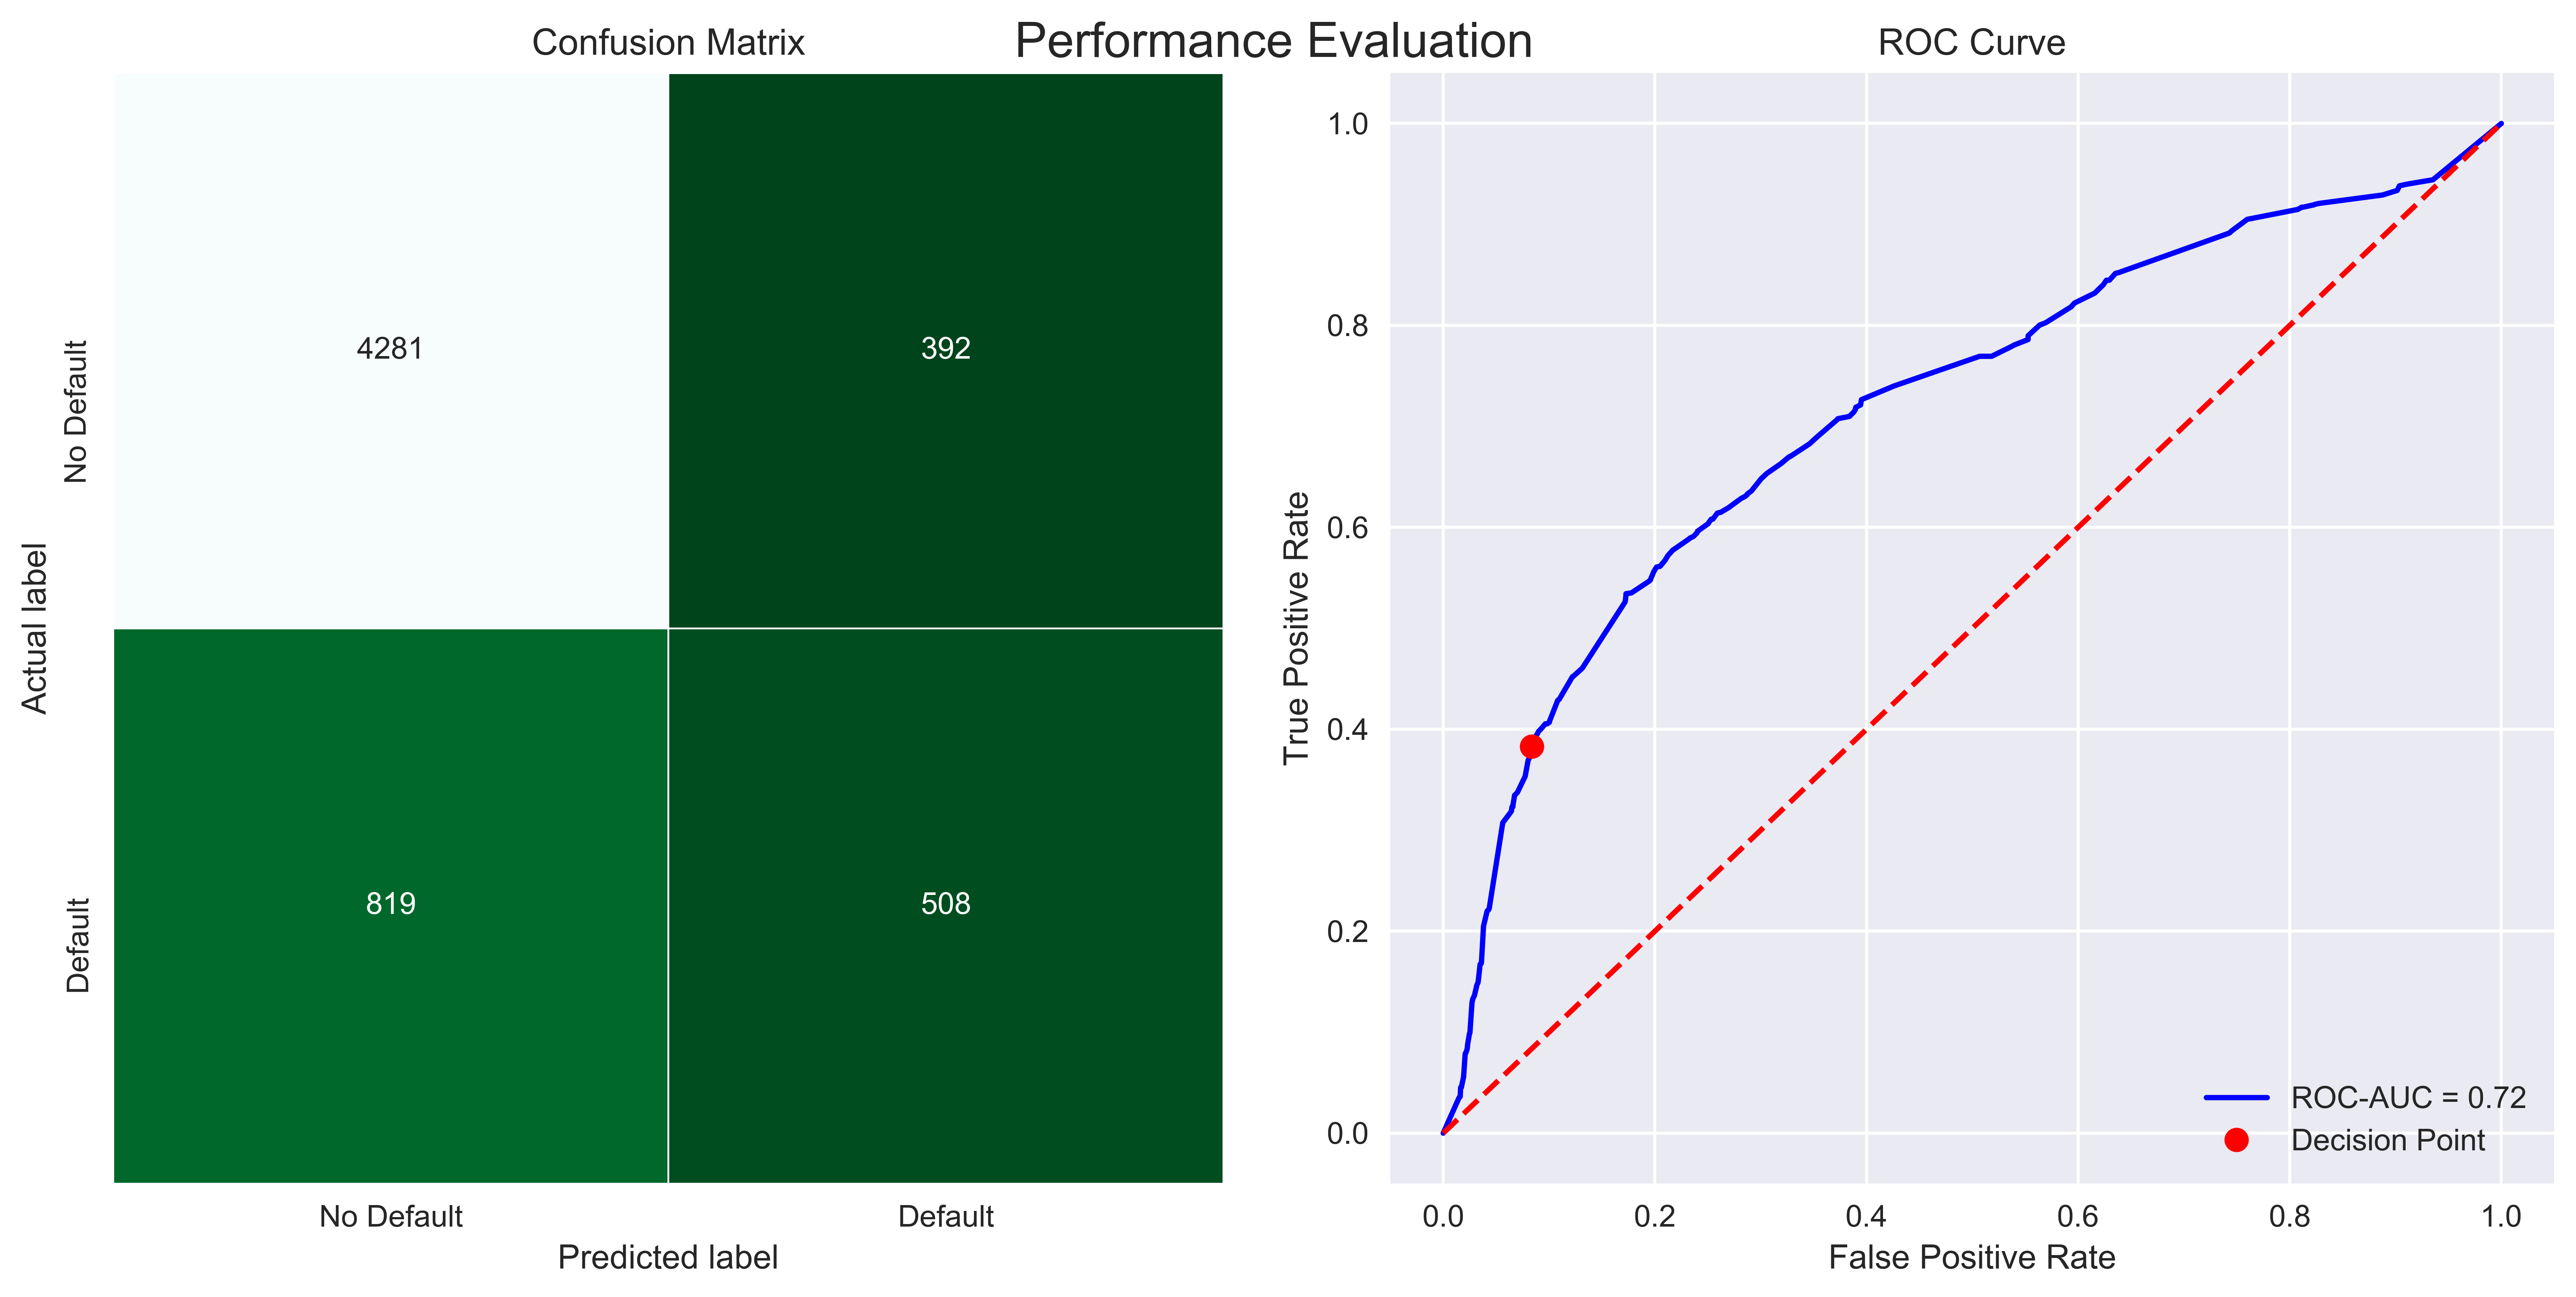

In [ ]:
LABELS = ['No Default', 'Default']
tree_gs_perf = performance_evaluation_report(classifier_gs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True)

plt.tight_layout()
#plt.savefig('images/ch8_im20.png')
plt.show()

In [ ]:
tree_gs_perf

{'accuracy': 0.7981666666666667,
 'precision': 0.5644444444444444,
 'recall': 0.38281838733986434,
 'specificity': 0.9161138454953991,
 'f1_score': 0.4562191288729232,
 'cohens_kappa': 0.3378533544753678,
 'roc_auc': 0.7184890319752828,
 'pr_auc': 0.4454415497075015}

8. Run Randomized Grid Search:

In [ ]:
classifier_rs = RandomizedSearchCV(tree_pipeline, param_grid, scoring='recall', 
                                   cv=k_fold, n_jobs=-1, verbose=1, 
                                   n_iter=100, random_state=42)
classifier_rs.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.2min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('numerical',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('imputer',
                                                                                                SimpleImputer(add_indi

In [ ]:
print(f'Best parameters: {classifier_rs.best_params_}') 
print(f'Recall (Training set): {classifier_rs.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, classifier_rs.predict(X_test)):.4f}')

Best parameters: {'preprocessor__numerical__outliers__n_std': 4, 'classifier__min_samples_leaf': 5, 'classifier__max_depth': 10, 'classifier__criterion': 'gini'}
Recall (Training set): 0.3905
Recall (Test set): 0.3723


9. Evaluate the performance of the Randomized Grid Search:

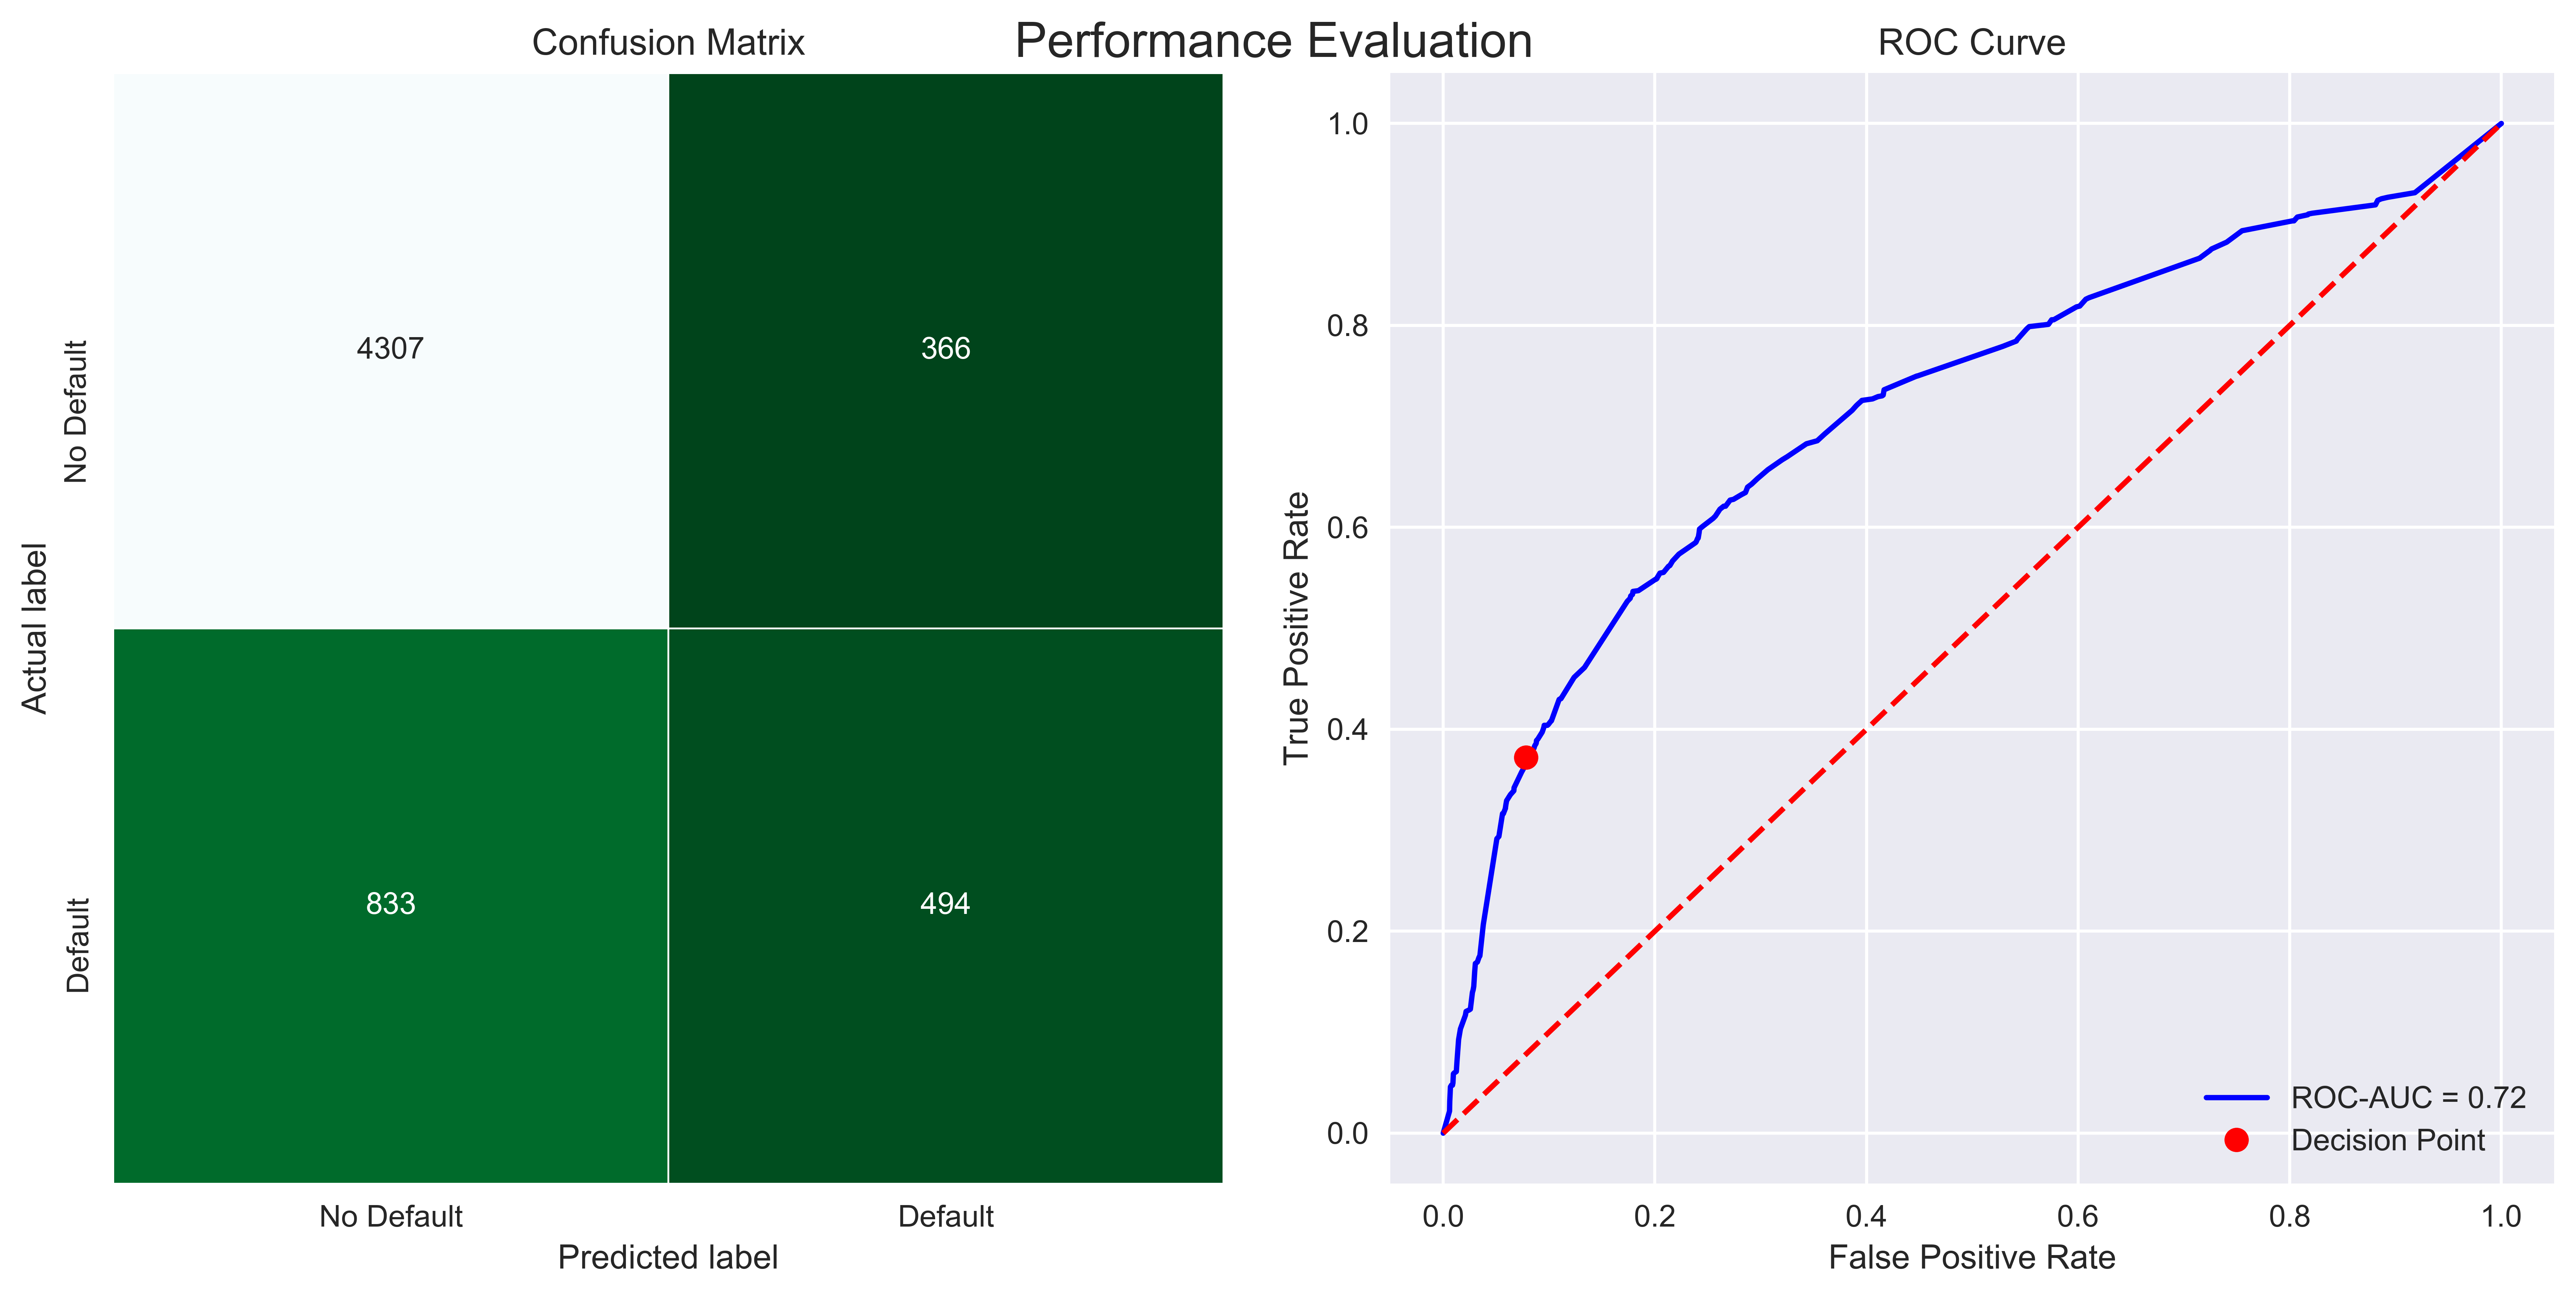

In [ ]:
tree_rs_perf = performance_evaluation_report(classifier_rs, X_test, 
                                             y_test, labels=LABELS, 
                                             show_plot=True)

plt.tight_layout()
plt.savefig('images/ch8_im21.png')
plt.show()

In [ ]:
tree_rs_perf

{'accuracy': 0.8001666666666667,
 'precision': 0.5744186046511628,
 'recall': 0.37226827430293896,
 'specificity': 0.921677723090092,
 'f1_score': 0.45176040237768633,
 'cohens_kappa': 0.3363199244249766,
 'roc_auc': 0.7167138547518646,
 'pr_auc': 0.4584613139689304}

### There's more

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
param_grid = [{'classifier': [LogisticRegression()],
               'classifier__penalty': ['l1', 'l2'],
               'classifier__C': np.logspace(0, 3, 10, 2),
               'preprocessor__numerical__outliers__n_std': [3, 4]},
              {'classifier': [DecisionTreeClassifier(random_state=42)],
               'classifier__criterion': ['entropy', 'gini'],
               'classifier__max_depth': range(3, 11),
               'classifier__min_samples_leaf': range(2, 11),
               'preprocessor__numerical__outliers__n_std': [3, 4]}]

In [ ]:
classifier_gs_2 = GridSearchCV(tree_pipeline, param_grid, scoring='recall', 
                               cv=k_fold, n_jobs=-1, verbose=1)

classifier_gs_2.fit(X_train, y_train)

print(f'Best parameters: {classifier_gs_2.best_params_}') 
print(f'Recall (Training set): {classifier_gs_2.best_score_:.4f}') 
print(f'Recall (Test set): {metrics.recall_score(y_test, classifier_gs_2.predict(X_test)):.4f}')

Fitting 5 folds for each of 328 candidates, totalling 1640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1640 out of 1640 | elapsed:  7.4min finished


Best parameters: {'classifier': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best'), 'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3, 'preprocessor__numerical__outliers__n_std': 3}
Recall (Training set): 0.3905
Recall (Test set): 0.3828
